In [162]:
import numpy as np
import astropy
import astropy.coordinates as ac
import astropy.units as u
import astropy.io
import astropy.table
import scipy
import pandas as pd
import galstreams
import gcutils
import gala
import gala.coordinates as gc
import sagittarius
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/cmateu/miniconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'zeros']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [189]:
def mean_of_skycoords(coo):
    """
    Compute vector mean of SkyCoord inputs. Returns SkyCoord object
    """
    sum_coo = ac.SkyCoord(x=np.sum(coo.cartesian.x),
                          y=np.sum(coo.cartesian.y),
                          z=np.sum(coo.cartesian.z),
                          frame=ac.ICRS, representation_type='cartesian')
    #Surely there's a more elegant way of doing this. No patience right now. This is pretty clearly right.
    sum_coo = ac.SkyCoord(ra=sum_coo.spherical.lon, dec=sum_coo.spherical.lat)
    #sum_coo = sum_coo.unitspherical ?
    
    return sum_coo

def get_track_from_points(sc, N=200, deg=7, stream_frame=None, mid_point=None):
    """ Estimate the mean track from a set of stream stars or points 

        Parameters
        ----------
        sc : `astropy.coordinates.SkyCoord` instance 

    """
    
    
    #find mean
    center=mean_of_skycoords(sc)

    if sc.ra.size<10: aux = ac.SkyCoord(ra=sc[[0,-1]].ra.value,dec=sc[[0,-1]].dec.value,unit=u.deg)
    else: aux = ac.SkyCoord(ra=sc[[5,-5]].ra.value,dec=sc[[5,-5]].dec.value,unit=u.deg)
    
    
    pole = gc.greatcircle.pole_from_endpoints(aux[0],aux[1])
    if stream_frame is not None: fr = stream_frame
    else: fr = gc.GreatCircleICRSFrame(pole=pole,ra0=center.ra)
    scp = sc.transform_to(fr)
    
    phi1s = np.linspace(np.min(scp.phi1),np.max(scp.phi1),N)
    phi2_fit = np.poly1d(np.polyfit(scp.phi1.deg,scp.phi2.deg, deg=deg))

    phi1_end_points = phi1s[[0,-1]]
    
    mean_phi1 = np.mean(phi1_end_points)
    phi2_mid = phi2_fit(mean_phi1.value)*scp.phi2.unit

    if mid_point is None: track_mid_point = ac.SkyCoord(phi1=mean_phi1, phi2=phi2_mid, frame=fr)
    else: track_mid_point = mid_point.transform_to(fr)
        
    #Initial track object
    track = ac.SkyCoord(phi1=phi1s, phi2=phi2_fit(phi1s.value)*u.deg, frame=fr)

    #In general phi1=0 in the initial guess frame is not necesarily contained between the end points
    if stream_frame is not None: new_fr = stream_frame
    else:    
        #Recompute the track using two points in the track, close to the center, at both sides (this ensures mid point is close to phi2=0)
        two_points_near_mid = ac.SkyCoord(phi1=[mean_phi1-0.5*u.deg,mean_phi1+0.5*u.deg]*u.deg, phi2=phi2_fit([mean_phi1.deg-0.5,mean_phi1.deg+0.5])*u.deg, frame=fr)
        aux=ac.SkyCoord(ra=two_points_near_mid.transform_to(ac.ICRS).ra.value, dec=two_points_near_mid.transform_to(ac.ICRS).dec.value, unit=u.deg)
        new_pole = gc.greatcircle.pole_from_endpoints(aux[0],aux[1])
        #New stream's frame -------------------------------------------------------------------
        new_fr = gc.GreatCircleICRSFrame(pole=new_pole, ra0=track_mid_point.icrs.ra)
        
    scp = sc.transform_to(new_fr)

    phi1s = np.linspace(np.min(scp.phi1),np.max(scp.phi1),N)
    phi1_end_points = phi1s[[0,-1]]
    
    #Set up polynomial fit with explicit frame so it can take a SkyCoord object in any frame and do it's magic
    phi2_fit = np.poly1d(np.polyfit(scp.phi1.deg,scp.phi2.value, deg=deg))
    phi2_track = phi2_fit(phi1s.deg)*scp.phi2.unit
    phi2_end = phi2_track[[0,-1]]
    mean_phi1 = np.mean(phi1_end_points)
    phi2_mid = phi2_fit([mean_phi1.value,])*scp.phi2.unit
    
    
    mid_dict = dict(frame=new_fr, phi1=mean_phi1, phi2=phi2_mid)
    end_dict = dict(frame=new_fr, phi1= phi1_end_points, phi2=phi2_end)
    track_dict = dict(frame=new_fr, phi1 = phi1s, phi2 = phi2_track)
    fits = dict(phi2=phi2_fit)
    
    for att in ["distance", "pm_phi1_cosphi2", "pm_phi2",  "radial_velocity"]:
        if att=="distance" or 's' in scp.data.differentials:  #i.e. if obj contains velocity data
            att_fit = np.poly1d(np.polyfit(scp.phi1.deg, getattr(scp,att).value, deg=deg))  #polynomial fit obj
            track_dict[att] = att_fit(phi1s.deg)*getattr(scp,att).unit   #eval track-fit to get track for current attr
            mid_dict[att] = att_fit([mean_phi1.value,])*getattr(scp,att).unit
            end_dict[att] = att_fit(phi1_end_points.deg)*getattr(scp,att).unit
        else:
            fits[att] = None
            track_dict[att] = None
            mid_dict[att] = None
            end_dict[att] = None

    newtrack = ac.SkyCoord(**track_dict)       
    track_end_points = ac.SkyCoord(**end_dict)
    
    if mid_point is None: track_mid_point = track_mid_point = ac.SkyCoord(**mid_dict)
    
 
    #Re-recompute stream frame to make sure mid_point ends up at phi1=0
    if stream_frame is not None: 
        new_fr = stream_frame
        new_pole = ac.SkyCoord(phi1=np.array([0.,])*u.deg, phi2=np.array([90.,])*u.deg, frame=new_fr)
    else:    
        if np.ndim(track_mid_point.transform_to(ac.ICRS).ra)==0: ra0=track_mid_point.transform_to(ac.ICRS).ra
        else: ra0=track_mid_point.transform_to(ac.ICRS).ra[0]    
        new_fr = gc.GreatCircleICRSFrame(pole=new_pole, ra0=ra0)
        #Re-store so that new_pole is iterable. Saves me trouble later
        new_pole = ac.SkyCoord(ra=np.array([new_pole.ra.deg,]), dec=np.array([new_pole.dec.deg,]), unit=u.deg)

    #Store width track
    track_width = np.std(scp.phi2)*np.ones(newtrack.phi2.size)  #TODO: turn this into rolling std
    

    return (newtrack.icrs, track_width, track_end_points.icrs, track_mid_point.icrs, 
            new_pole.icrs, new_fr, fits)



In [190]:
def save_track_ecsv(outfilen,track):
    
    #Save track
    names = track.get_representation_component_names()
    names.update(track.get_representation_component_names('s'))
    t = astropy.table.QTable( {k: getattr(track, k) for k in names})
    astropy.io.ascii.write(t, format='ecsv', delimiter=',', output=outfilen, overwrite=True, fast_writer=False)   


def save_summary_ecsv(outfilen, track_end_points, track_mid_point, mid_pole, StreamName="0", StreamShortName="0", InfoFlags="0000"):
    
    #InfoFlags "XYZW": X=0 : track is assumed to be great circle (i.e. no detailed celestial track info). Y,Z,W=0: no distance, pm vrad gradient info respectively.
    
    #Save track summary - one line per stream. Yes, I prefer this. That way each stream's summary can be independently updated. 
    #ofilesn = f"{ofileroot}.summary.ecsv"
    names = track_end_points.get_representation_component_names()
    names.update(track_end_points.get_representation_component_names('s'))
    
    
    tr_summary = dict(StreamName=np.array([StreamName,]), StreamShortName=np.array([StreamShortName,]), InfoFlags=np.array([InfoFlags,]) )
    lnames = [ "end_o."+k for k in names]
    tr_summary.update({l: getattr(track_end_points[:1], k) for k,l in zip(names,lnames)})
    lnames = [ "end_f."+k for k in names]
    tr_summary.update({l: getattr(track_end_points[1:], k) for k,l in zip(names,lnames)})
    lnames = [ "mid."+k for k in names]
    tr_summary.update({l: getattr(track_mid_point[:1], k) for k,l in zip(names,lnames)})
    rnames = mid_pole.get_representation_component_names()
    lnames = [ "pole."+k for k in rnames]
    tr_summary.update({l: getattr(mid_pole[:1], k) for k,l in zip(rnames,lnames)})
    #print track summary
    t = astropy.table.QTable(tr_summary)
    astropy.io.ascii.write(t, format='ecsv', delimiter=',', output=outfilen, overwrite=True, fast_writer=False)   
    

In [191]:
def stream_plot(stream_sc, track, track_end_points, track_mid_point, stream_fr, saveplot=False, clf=False, StreamName=None, plotfilen='salida.png', plot_obs=True):
    
    pkwds=dict(marker='.',ls='', alpha=0.5)
    tkwds=dict(marker='',ls='-', lw=2, color='orange')
    mkw=dict(marker='D',ls='', color='k')
    ekw=dict(marker='o',ls='', color='k')

    nx, ny = 2, 5
    fig=plt.figure(1,figsize=(10,10))
    axs = fig.subplots(ny,nx, sharex="col")

    if plot_obs: stream_plot_card(stream_sc, stream_fr, axs, plotkwds=pkwds )
    stream_plot_card(track, stream_fr, axs, plotkwds=tkwds)
    stream_plot_card(track_end_points, stream_fr, axs, plotkwds=ekw)
    stream_plot_card(track_mid_point, stream_fr, axs, plotkwds=mkw, show_labels=True)
    
    if StreamName: fig.suptitle("Stream: "+StreamName) 

    fig.tight_layout(rect=[0,0,1,0.97])

    if saveplot: fig.savefig(plotfilen)
    if clf:     fig.clf()


In [195]:
def stream_plot_card(sc, stream_fr, axs, plotkwds={}, show_labels=False, show_grid=False):

    

    labels1=dict(phi2="$\phi_2$ ($\degree$)", distance="$D$ (kpc)", 
                 pm_phi1_cosphi2="$\mu\phi1$ (mas/yr)", pm_phi2="$\mu\phi2$ (mas/yr)",
                 radial_velocity="$v_r$ (km/s)")
    labels2=dict(ra="$\\alpha$ ($\degree$)",dec="$\delta$ ($\degree$)", distance="$D$ (kpc)", 
                 pm_ra_cosdec="$\mu\\alpha$ (mas/yr)", pm_dec="$\mu\delta$ (mas/yr)",
                 radial_velocity="$v_r$ (km/s)")
    
    #Plots in stream frame coords    
    r,c=0,0    
    for att in ["phi2","distance", "pm_phi1_cosphi2", "pm_phi2",  "radial_velocity"]:
        try:
            if att=="distance" or 's' in sc.data.differentials:  #i.e. if obj contains velocity data
                axs[r,c].plot(sc.transform_to(stream_fr).phi1, getattr(sc.transform_to(stream_fr),att), **plotkwds)
                if (np.abs(getattr(sc.transform_to(stream_fr),att).value)>1e-9).sum()==0 :
                    axs[r,0].set_ylim(-10,10)
        except TypeError or ValueError: print("No kinematic data...")        
        if show_grid: axs[r,c].grid()
        if show_labels:
            if axs[r,c].is_last_row(): axs[r,c].set_xlabel("$\phi_1$ ($\degree$)")
            axs[r,c].set_ylabel(labels1[att])
        r=r+1

    #Plots in equatorial coords
    r,c=0,1  
    for att in ["dec","distance", "pm_ra_cosdec", "pm_dec",  "radial_velocity"]:
        try:
            #if hasattr(sc.icrs, att): 
            if att=="distance" or 's' in sc.data.differentials:  #i.e. if obj contains velocity data
                axs[r,c].plot(sc.icrs.ra, getattr(sc.icrs,att), **plotkwds)
                if (np.abs(getattr(sc.icrs,att).value)>1e-9).sum()==0 :
                    #axs[r,0].set_ylim(-10,10)
                    axs[r,1].set_ylim(-10,10)       
        except TypeError or ValueError: print("No kinematic data...")                        
        if show_grid: axs[r,c].grid()
        if show_labels:
            if axs[r,c].is_last_row(): axs[r,c].set_xlabel("$\\alpha$ ($\degree$)")
            axs[r,c].set_ylabel(labels2[att])
            
        r=r+1
    
    #return f, axs

In [196]:
def generate_track_from_points_plot_and_store(obs, Name, Ref, mid_point=None, stream_frame=None, deg=3, ShortName=None, InfoFlags="0000",
                                              clf=True, plot_obs=True, plot_ext=".st", verbose=True, return_track=False, return_all=False, do_not_store=False):
    '''
        Generate track from points, plot it and store track and track summary in ecsv files
        
        Parameters:
        
        obs: SkyCoord Object. Must contain velocity data
        
        Name: String - Stream's name
        
        Ref: String - Main Reference for stream track
        
        Optional:
        
        mid_point: SkyCoord - not implemented yet. When it is it will override the auto-computed mid_point
    '''
    
    if ShortName is None:  ShortName=Name[:3]

    track, track_width, track_end_points, track_mid_point, mid_pole, stream_fr, track_fits = get_track_from_points(obs.icrs, deg=deg, stream_frame=stream_frame, mid_point=mid_point)

    #Print track out
    ofileroot = f"track{plot_ext}.{Name}.{Ref.lower()}"
    ofilesn = f"{ofileroot}.summary.ecsv"    
    
    if not do_not_store:
        if verbose: print(f"{Name} -> {ofileroot}.ecsv")
        save_track_ecsv(f"{ofileroot}.ecsv",track)

        #Save track summary - one line per stream. Yes, I prefer this. That way each stream's summary can be independently updated. 
        save_summary_ecsv(ofilesn, track_end_points, track_mid_point, mid_pole, StreamName=Name, StreamShortName=ShortName, InfoFlags=InfoFlags)

    #While we're at it. Make plot and save
    if do_not_store: saveplot=False
    else: saveplot=True    
    stream_plot(obs, track, track_end_points, track_mid_point, stream_fr, saveplot=saveplot, plotfilen=ofileroot+".png",  clf=clf, StreamName=Name, plot_obs=plot_obs)
    
    #Save poly-footprint
    #here...

    if return_all: return track, track_width, track_end_points, track_mid_point, mid_pole, stream_fr, track_fits
    elif return_track: return track


In [197]:
# def uncorrect_solar_reflex(sc, galcen_distance=8.34*u.kpc, galcen_v_sun=(11.1,240.+12.24,7.25)*u.km/u.s ) :
# #Defaults: Sun's peculiar velocity from Schönrich, R., Binney, J., & Dehnen, W. 2010, MNRAS, 403, 1829. 
# #VLSR=240 and Rsun=8.34kpc from Reid, M. J., Menten, K. M., Brunthaler, A., et al. 2014, ApJ, 783, 130

#     #Solar reflex motion contribution in stream coords (zero vels at object's coordinates)
#     zeros = np.zeros(sc.galactic.l.size)
#     zz = ac.SkyCoord(l=sc.galactic.l, b=sc.galactic.b, distance=sc.galactic.distance, frame='galactic',
#                      pm_l_cosb=zeros*u.mas/u.yr, pm_b=zeros*u.mas/u.yr, radial_velocity=zeros*u.km/u.s)
    
#     sun_reflex = gc.reflex_correct(zz, galactocentric_frame=ac.Galactocentric(galcen_distance=galcen_distance, galcen_v_sun=galcen_v_sun))

    
#     uncorr = ac.SkyCoord(l=sc.galactic.l, b=sc.galactic.b, distance=sc.galactic.distance, frame='galactic',
#                           pm_l_cosb= sc.galactic.pm_l_cosb - sun_reflex.pm_l_cosb,   #everything is in galactic by construction (this is arbitrary)
#                           pm_b = sc.galactic.pm_b - sun_reflex.pm_b,
#                           radial_velocity = sc.galactic.radial_velocity - sun_reflex.radial_velocity)
                           
#     return uncorr.transform_to(sc.frame)


Tracks init by end points
==========================

Notes on individual streams:

**Pal 13**: We did not report a pm track in Shipp et al. 2020. There are too few RRL in the stream (3) to infer this. A more careful photmetric member selection would need to be done to provide this.

In [198]:
tpair = astropy.io.ascii.read("../support_data/lib_by_pair.dat",header_start=4)
#tpair.replace_column('Ro', tpair["Ro"].astype(float))
tpair

Name,ShortName,lono,lato,lonf,latf,frame,Ro,Rf,Width,pm_lon_coslat,pm_lat,pm_frame,reflex_corrected,ep_Reference,pm_Reference,R00,R01,R02,R10,R11,R12,R20,R21,R22,R-Reference
str11,str5,float64,float64,float64,float64,str3,float64,float64,float64,float64,float64,str6,str4,str26,str9,float64,float64,float64,float64,float64,float64,float64,float64,float64,str6
Acheron,Ach,230.0,-2.0,259.0,21.0,equ,3.5,3.8,0.9,--,--,icrs,True,Grillmair2009,--,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,''
Cocytos,Coc,186.0,-3.0,259.0,20.0,equ,11.0,11.0,0.7,--,--,icrs,True,Grillmair2009,--,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,''
Lethe,Let,171.0,18.0,258.0,20.0,equ,13.0,13.0,0.4,--,--,icrs,True,Grillmair2009,--,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,''
Styx,Sty,194.0,20.0,259.0,21.0,equ,45.0,45.0,3.3,--,--,icrs,True,Grillmair2009,--,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,''
Chenab,Che,-40.7,-59.9,-28.3,-43.0,equ,39.8,39.8,0.71,1.03,-0.6,stream,True,Shipp2018,Shipp2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,''
Elqui,Elq,10.7,-36.9,20.6,-42.4,equ,50.1,50.1,0.54,0.56,-0.03,stream,True,Shipp2018,Shipp2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,''
Indus,Ind,-36.3,-50.7,-8.0,-64.8,equ,16.6,16.6,0.83,-3.09,0.21,stream,True,Shipp2018,Shipp2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,''
Palca,Pca,30.3,-53.7,16.2,2.4,equ,36.3,36.3,0.0,--,--,stream,True,Shipp2018,--,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,''
Phoenix,Phe,20.0,-57.0,27.0,-45.0,equ,17.5,17.5,0.18,-1.94,-0.36,stream,True,Balbinot2016,--,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,''


In [199]:
gcstep=0.1
coo_frame=dict(equ="icrs",gal="galactic",Galactocentric="GC")

for i in range(tpair["lono"].size)[:]:

    Name, ShortName, Reference = tpair["Name"][i], tpair["ShortName"][i], tpair["ep_Reference"][i] 
    print(i,Name)

    #End points
    track_end_point_o = ac.SkyCoord(tpair["lono"][i]*u.deg ,tpair["lato"][i]*u.deg, frame=coo_frame[tpair["frame"][i]])
    track_end_point_f = ac.SkyCoord(tpair["lonf"][i]*u.deg ,tpair["latf"][i]*u.deg, frame=coo_frame[tpair["frame"][i]])

    track_end_points = ac.SkyCoord(np.array([tpair["lono"][i],tpair["lonf"][i]])*u.deg,
                                   np.array([tpair["lato"][i],tpair["latf"][i]])*u.deg,
                                   distance=np.array([tpair["Ro"][i],tpair["Rf"][i]])*u.kpc,
                                   frame=coo_frame[tpair["frame"][i]],
                                   pm_ra_cosdec=np.zeros(2)*u.arcsec/u.yr, 
                                   pm_dec=np.zeros(2)*u.arcsec/u.yr)

    
    #Mid point. This track is, by definitiion a great circle. In this case, it is valid that the mean will be in the same plane and thus a valid mid-point
    track_mid_point = mean_of_skycoords(track_end_points)   
    
    mid_pole = gc.greatcircle.pole_from_endpoints(track_end_point_o, track_end_point_f)
    stream_fr = gc.GreatCircleICRSFrame(pole=mid_pole, ra0=track_mid_point.ra)
    
    #Generate sky track
    phis_o=np.linspace( (track_end_points.transform_to(stream_fr).phi1.value).min(),  (track_end_points.transform_to(stream_fr).phi1.value).max(), 200)
    phi1s = phis_o*track_end_points.ra.unit
    phi2 = np.zeros(phi1s.size)*phi1s.unit
    
    #Distance track - If a detailed track is lacking and only Ro,Rf are reported, nothing better to do than linear interpolation
    Fd = scipy.interpolate.interp1d([phis_o[0],phis_o[-1]],[tpair["Ro"][i],tpair["Rf"][i]],kind='linear',bounds_error=False)
    distance = Fd(phi1s.value)*u.kpc    #Ro,Rf are passed in kpc

    
    #In this category, for now it's assumed no proper motion data is available. If it is, move to Individual stream category
    track = ac.SkyCoord(phi1=phi1s, phi2=phi2, 
                        distance=distance,
                        frame=stream_fr, 
                        pm_phi1_cosphi2=np.zeros(phi2.size)*u.arcsec/u.yr, 
                        pm_phi2=np.zeros(phi2.size)*u.arcsec/u.yr)

    #Objects are stored in icrs by default
    mid_point_distance = Fd(track_mid_point.transform_to(stream_fr).phi1.value)*u.kpc
    
    track_mid_point = ac.SkyCoord(ra=track_mid_point.ra*np.ones(1), dec=track_mid_point.dec*np.ones(1), 
                                  distance=Fd(0.)*u.kpc, frame="icrs", 
                                  pm_ra_cosdec=np.zeros(1)*u.arcsec/u.yr, pm_dec=np.zeros(1)*u.arcsec/u.yr )    

    #Make sure we have proper fill values if pms are not available
    if not tpair["pm_lon_coslat"][i]: tpair["pm_lon_coslat"][i], tpair["pm_lat"][i] = 0., 0.

    if tpair["pm_frame"][i]=="stream": frame = stream_fr
    else: frame = tpair["pm_frame"][i]    
    
    track_mid_point = track_mid_point.transform_to(frame) 
    
    #Create aux dict with the attribute names in that coord system 
    onames = track_mid_point.get_representation_component_names()
    onames.update(track_mid_point.get_representation_component_names('s'))
    names = dict((v,k) for k,v in onames.items()) #flip it so that lon, lat, pm_lon_coslat, etc are the keys and not the values

    
    mid_point_dict =     {names["lon"] : getattr(track_mid_point,names["lon"]),
                          names["lat"] : getattr(track_mid_point,names["lat"]),
                          names["distance"] : mid_point_distance,
                          names["d_lon_coslat"] : np.array([tpair["pm_lon_coslat"][i],])*u.mas/u.yr,
                          names["d_lat"] : np.array([tpair["pm_lat"][i],])*u.mas/u.yr,
                          names["d_distance"]: np.array([-999.,])*u.km/u.s,
                          "frame": frame}    
    
    track_mid_point=ac.SkyCoord(**mid_point_dict)
    
    #Finally, if necessary, undo solar reflex correction
    Vsun_GSR = np.array([11.1,240.+12.24,7.25])*u.km/u.s #Schoenrich, Binney & Dennen 2010
    if bool(tpair["reflex_corrected"][i]):
        #To remove correction, apply it but with opposite vel for the sun
        track_mid_point = gc.reflex_correct(track_mid_point, 
                                            galactocentric_frame=ac.Galactocentric(galcen_distance=8.34*u.kpc, galcen_v_sun= -Vsun_GSR))


    #Store pole with needed shape    
    mid_pole = ac.SkyCoord(ra=mid_pole.ra*np.ones(1), dec=mid_pole.dec*np.ones(1), distance=np.zeros(1), frame="icrs") 
                           #pm_ra_cosdec=np.zeros(1)*u.mas/u.yr, pm_dec=np.zeros(1)*u.mas/u.yr )


    ofileroot = f"track.ep.{Name}.{Reference.lower()}"

    #Save plots
    stream_plot(track, track, track_end_points, track_mid_point, stream_fr, saveplot=True, plotfilen=ofileroot+".png", clf=True, StreamName=Name, plot_obs=False)

    #Print track out
    ofileroot = f"track.ep.{Name}.{Reference.lower()}"
    print(f"{Name} -> {ofileroot}.ecsv")
    save_track_ecsv(f"{ofileroot}.ecsv",track = track.icrs)

    #Save track summary - one line per stream. Yes, I prefer this. That way each stream's summary can be independently updated. 
    ofilesn = f"{ofileroot}.summary.ecsv"    
    save_summary_ecsv(ofilesn, track_end_points.icrs, track_mid_point.icrs, mid_pole.icrs, StreamName=Name, StreamShortName=ShortName, InfoFlags="0000" )
    


0 Acheron
Acheron -> track.ep.Acheron.grillmair2009.ecsv
1 Cocytos
Cocytos -> track.ep.Cocytos.grillmair2009.ecsv
2 Lethe
Lethe -> track.ep.Lethe.grillmair2009.ecsv
3 Styx
Styx -> track.ep.Styx.grillmair2009.ecsv
4 Chenab
Chenab -> track.ep.Chenab.shipp2018.ecsv
5 Elqui
Elqui -> track.ep.Elqui.shipp2018.ecsv
6 Indus
Indus -> track.ep.Indus.shipp2018.ecsv
7 Palca
Palca -> track.ep.Palca.shipp2018.ecsv
8 Phoenix
Phoenix -> track.ep.Phoenix.balbinot2016.ecsv
9 Ravi
Ravi -> track.ep.Ravi.shipp2018.ecsv
10 TucanaIII
TucanaIII -> track.ep.TucanaIII.shipp2018,drlicawagner2015.ecsv
11 Turbio
Turbio -> track.ep.Turbio.shipp2018.ecsv
12 Turranburra
Turranburra -> track.ep.Turranburra.shipp2018.ecsv
13 Wambelong
Wambelong -> track.ep.Wambelong.shipp2018.ecsv
14 Willka_Yaku
Willka_Yaku -> track.ep.Willka_Yaku.shipp2018.ecsv
15 Jet
Jet -> track.ep.Jet.jethwa2017.ecsv
16 Gaia-3
Gaia-3 -> track.ep.Gaia-3.malhan2018.ecsv
17 Gaia-4
Gaia-4 -> track.ep.Gaia-4.malhan2018.ecsv
18 Gaia-5
Gaia-5 -> track.ep.

<Figure size 720x720 with 0 Axes>

In [17]:
util = ac.SkyCoord(0.,0.,unit=u.deg, frame=tpair["pm_frame"][i]) 
names = util.get_representation_component_names()
names.update(util.get_representation_component_names('s'))
names

OrderedDict([('ra', 'lon'),
             ('dec', 'lat'),
             ('distance', 'distance'),
             ('pm_ra_cosdec', 'd_lon_coslat'),
             ('pm_dec', 'd_lat'),
             ('radial_velocity', 'd_distance')])

In [89]:
mwsts=galstreams.MWStreams(verbose=False)

/Users/cmateu/miniconda3/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


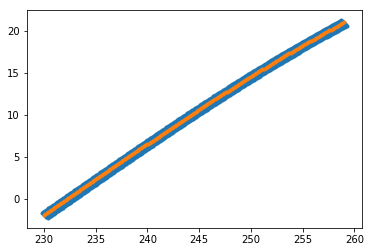

In [14]:
#Read-in validation
ofilen="track.ep.Acheron.grillmair2009.ecsv"
t = astropy.table.QTable.read(ofilen)
sc = ac.SkyCoord(**t)

#rr=astropy.io.ascii.read(ofilen, format='ecsv')   
#rr["sc"].ra
plt.plot(mwsts["Acheron"].ra,mwsts["Acheron"].dec,'.')
plt.plot(sc.ra.deg,sc.dec.deg,'.')

Tracks init by pole
====================

In [201]:
tpoles = astropy.io.ascii.read("../support_data/lib_by_pole.dat",header_start=2)
tpoles

Name,pole_lon,pole_lat,pole_frame,center_lon,center_lat,cent_frame,dlon_deg,dlat,Ro,Rf,ShortName,Reference
str9,float64,float64,str3,float64,float64,str3,float64,float64,float64,float64,str6,str13
PS1-A,300.856,20.732,equ,160.17,-62.27,gal,5.0,0.45,7.9,7.9,PS1-A,Bernard2016
PS1-B,65.603,32.567,equ,248.41,32.3,gal,10.0,0.45,14.5,14.5,PS1-B,Bernard2016
PS1-C,232.227,33.838,equ,75.12,-32.6,gal,8.0,0.333,17.4,17.4,PS1-C,Bernard2016
PS1-D,49.64,2.467,equ,231.06,32.83,gal,45.0,0.867,22.9,22.9,PS1-D,Bernard2016
PS1-E,42.526,23.987,equ,144.17,58.4,gal,25.0,0.617,12.6,12.6,PS1-E,Bernard2016
Ophiuchus,184.32,77.25,equ,4.53,31.69,gal,2.5,0.12,9.5,9.5,Oph,Bernard2014
Sangarius,178.0,-52.0,gal,149.01,7.847,equ,59.0,0.44,21.0,21.0,San,Grillmair2017
Scamander,196.0,-41.0,gal,153.52,12.46,equ,66.0,0.22,21.0,21.0,Sca,Grillmair2017
Corvus,104.5,32.46,GC,288.98,46.21,gal,80.0,0.0,11.0,11.0,Crv,Mateu2018


In [202]:
coo_frame=dict(equ="icrs",gal="galactic",Galactocentric="GC")
gcstep=0.1
tp=tpoles
for i in range(tp["Name"].size)[:]:
    _ = ac.galactocentric_frame_defaults.set('v4.0') 
    Name, ShortName=tp["Name"][i], tp["ShortName"][i]
    Ref= tp["Reference"][i]
    
    print(Name)
    #Store pole and center coords, each in its own frame. 
    if "GC" not in tp["pole_frame"][i] and "GC" not in tp["cent_frame"][i]:
        pole_sc = ac.SkyCoord( tp["pole_lon"][i], tp["pole_lat"][i], unit=u.deg, frame=coo_frame[tp["pole_frame"][i]] )
        cent_sc = ac.SkyCoord( tp["center_lon"][i], tp["center_lat"][i], unit=u.deg, frame=coo_frame[tp["cent_frame"][i]] )
                             
        #Generate track from pole. Starting here, do everything in galactic
        azs,lats=gcutils.get_gc_for_pole(pole_sc.galactic.l.deg,pole_sc.galactic.b.deg,degree=True,
                                         center=[cent_sc.galactic.l.deg,cent_sc.galactic.b.deg],
                                         dlon=tp["dlon_deg"][i],dlat=0.,step=gcstep)
                                                                       
        distance = np.ones_like(azs)*tp["Ro"][i]   
        coo = ac.SkyCoord( l=azs*u.deg, b=lats*u.deg, frame="galactic", distance = distance*u.kpc,
                           pm_l_cosb=np.zeros(azs.size)*u.mas/u.yr, pm_b=np.zeros(azs.size)*u.mas/u.yr)
    else:
        if "GC" not in tp["cent_frame"][i]:
                cent_sc=ac.SkyCoord(tp["center_lon"][i]*u.deg, tp["center_lat"][i]*u.deg, frame=coo_frame[tp["cent_frame"][i]], 
                                    distance=tp["Ro"][i]*u.kpc)
                cent_in_GC=cent_sc.transform_to(ac.Galactocentric)                 
        azs,lats=gcutils.get_gc_for_pole( tp["pole_lon"][i],tp["pole_lat"][i],degree=True,
                                         center=[cent_in_GC.spherical.lon.deg,cent_in_GC.spherical.lat.deg],
                                         dlon=tp["dlon_deg"][i],dlat=0.,step=gcstep)
                                          
        distance=tp["Ro"][i]*np.ones_like(azs)                                                                     
        print(distance.mean(),azs.size)
        galcen = ac.SkyCoord(lon=azs*u.deg, lat=lats*u.deg, distance=distance*u.kpc, frame=ac.Galactocentric,  representation_type='spherical' )
        
        #Do it this way, instead of just gc.transform_to("galactic"), because extra info in SkyCoord obj due to Galactocentric initialization 
        #gives a RepresentationError when printing ecsv table
        coo = ac.SkyCoord(l=galcen.galactic.l, b=galcen.galactic.b, distance=galcen.galactic.distance, frame='galactic',
                          pm_l_cosb=np.zeros(distance.size)*u.mas/u.yr, pm_b=np.zeros(distance.size)*u.mas/u.yr)

    #All tracks generated by poles have InfoFlags=0000 by default, no gradient data is available    
    generate_track_from_points_plot_and_store(coo, Name, Ref, mid_point=None, ShortName=ShortName, deg=12, clf=True, plot_obs=True, plot_ext='.po', InfoFlags="0000")

PS1-A


PS1-A -> track.po.PS1-A.bernard2016.ecsv
PS1-B
PS1-B -> track.po.PS1-B.bernard2016.ecsv
PS1-C
PS1-C -> track.po.PS1-C.bernard2016.ecsv
PS1-D
PS1-D -> track.po.PS1-D.bernard2016.ecsv
PS1-E
PS1-E -> track.po.PS1-E.bernard2016.ecsv
Ophiuchus
Ophiuchus -> track.po.Ophiuchus.bernard2014.ecsv
Sangarius
Sangarius -> track.po.Sangarius.grillmair2017.ecsv
Scamander
Scamander -> track.po.Scamander.grillmair2017.ecsv
Corvus
11.0 799
Corvus -> track.po.Corvus.mateu2018.ecsv
20.0-1
20.0 496
20.0-1 -> track.po.20.0-1.mateu2018.ecsv


<Figure size 720x720 with 0 Axes>

Individually initialized tracks
===================================

Ibata 2020 streams
------------------

In [203]:
#Read data form Ibata' 2020sTable 1 (as provided)
ibt=astropy.io.ascii.read("../support_data/tab01.Ibata2020.cat")
ib=ac.SkyCoord(ra=ibt["ra_epoch2000"]*u.deg, dec=ibt["dec_epoch2000"]*u.deg, distance=ibt["dis"]*u.kpc, 
                pm_ra_cosdec=ibt["pmra"]*u.mas/u.yr, pm_dec=ibt["pmdec"]*u.mas/u.yr)#, radial_velocity=np.zeros(ibt["dis"].size)*u.km/u.s)
ibt["StreamName"] = ibt["dis"].astype(str)

In [204]:
#Use stream_number-StreamName mapping to create new column with stream name
nm=astropy.io.ascii.read("../support_data/tab01.legend.txt")
for ii in range(nm["N"].size):
    mask = ibt["stream"]== nm["N"][ii]
    ibt["StreamName"][mask] = nm["StreamName"][ii]
#Add it as attribute to SkyCoordObj
ib.StreamName=ibt["StreamName"]
#And save the table with the StreamName column, because, why not?
ibt.write("../support_data/tab01.Ibata2020.wnames.cat",format='ascii.commented_header', overwrite=True)

Skipping excluded stream: VOD/VSS
Skipping excluded stream: Monoceros
Skipping excluded stream: Her-Aq
Skipping excluded stream: Sgr-L10


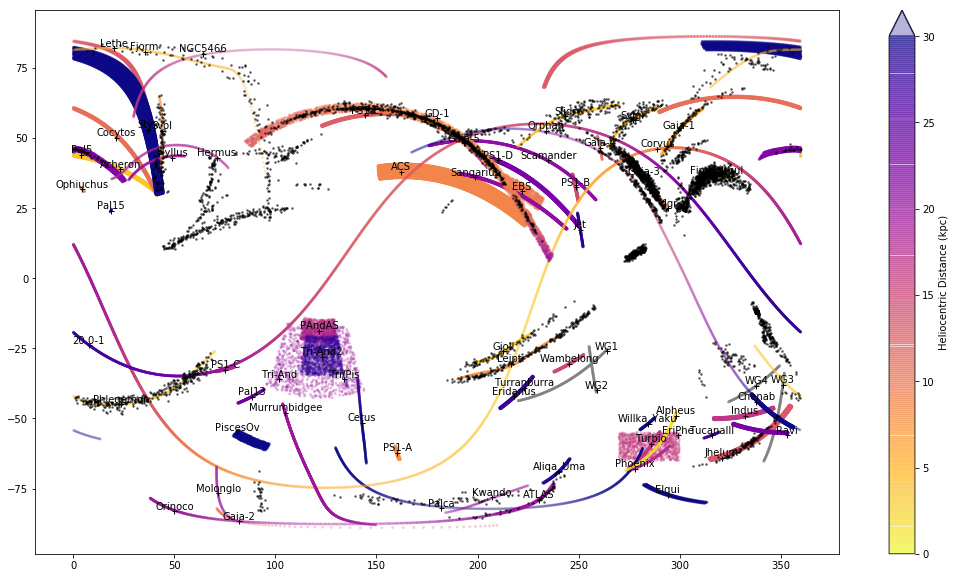

In [205]:
m=ib.StreamName=="GD-1"
#plt.plot(ib.galactic.l[m],ib.galactic.b[m],'.k')
fig=plt.figure(1,figsize=(18,10))
ax=fig.add_subplot(111)
cmapp=plt.cm.plasma_r
cmapp.set_under('grey')   #If distance info is missing (-1), plot in grey

mwsts.plot_stream_compilation(ax,plot_colorbar=True,scat_kwargs=dict(vmin=0.,vmax=30.,cmap=cmapp, alpha=0.3), exclude_streams=["Sgr-L10","Her-Aq","Monoceros","VOD/VSS"],
                                  use_shortnames=False, cb_kwargs=dict(label='Heliocentric Distance (kpc)'), 
                                  verbose=False)
ax.scatter(ib.galactic.l,ib.galactic.b,c='k',marker='.',s=10,alpha=0.5)



In [206]:
ib[m][-3]

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (218.8535533, 58.7747837, 11.9)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (-6.83, -1.416)>

In [101]:
#pole=gc.greatcircle.pole_from_endpoints(ib[m][0], ib[m][-3])

In [102]:
#np.unique(ib.stream)

In [207]:
i = 22 #8 22 #31
#It has to be done this way. I dont't know why, but using the full ib SKyCoord obj gives a representation error
#TypeError: Operation 'truediv' is not supported when differentials are attached to a CartesianRepresentation.
mask = ib.ra>195*u.deg
ibs = ib[m & mask]
Ref = "ibata2020"
for sname in np.unique(ib.StreamName)[:]:
    m = ib.StreamName==sname
    ibs = ib[m]
    Name=f"{sname}"

    #All the Ibata2020 streams have full 5D data, hence InfoFlags=1111
    generate_track_from_points_plot_and_store(ibs, Name, Ref, mid_point=None, ShortName=Name[:3], clf=True, plot_obs=True, InfoFlags="1111")


# Then, when reading it back in, it should be possible to do:
# t = at.QTable.read('filename.ecsv')
# sc = coord.SkyCoord(**t)




C-4 -> track.st.C-4.ibata2020.ecsv
C-5 -> track.st.C-5.ibata2020.ecsv
C-7 -> track.st.C-7.ibata2020.ecsv
C-8 -> track.st.C-8.ibata2020.ecsv
C-9 -> track.st.C-9.ibata2020.ecsv
Fimbulthul -> track.st.Fimbulthul.ibata2020.ecsv
Fjorm -> track.st.Fjorm.ibata2020.ecsv
GD-1 -> track.st.GD-1.ibata2020.ecsv
Gaia-1 -> track.st.Gaia-1.ibata2020.ecsv
Gaia-11 -> track.st.Gaia-11.ibata2020.ecsv
Gaia-2 -> track.st.Gaia-2.ibata2020.ecsv
Gaia-8 -> track.st.Gaia-8.ibata2020.ecsv
Gaia-9 -> track.st.Gaia-9.ibata2020.ecsv
Gjoll -> track.st.Gjoll.ibata2020.ecsv
Gunnthra -> track.st.Gunnthra.ibata2020.ecsv
Hrid -> track.st.Hrid.ibata2020.ecsv
Jhelum -> track.st.Jhelum.ibata2020.ecsv
Kshir -> track.st.Kshir.ibata2020.ecsv
Leiptr -> track.st.Leiptr.ibata2020.ecsv
M5 -> track.st.M5.ibata2020.ecsv
M68 -> track.st.M68.ibata2020.ecsv
M92 -> track.st.M92.ibata2020.ecsv
NGC3201 -> track.st.NGC3201.ibata2020.ecsv
NGC6397 -> track.st.NGC6397.ibata2020.ecsv
Orphan -> track.st.Orphan.ibata2020.ecsv
Pal5 -> track.st.Pal5

<Figure size 720x720 with 0 Axes>

Alpheus
========

Alpheus  is implemented from the polynomial fit provided by Grillmair et al. 2013 in their Eq. 1 :

$\alpha = 32.116-0.00256\delta-0.00225\delta^2$

with $\delta \in [-69^\circ,-45^\circ]$. The authors report mean heliocentric distances of 2 and 1.6~kpc respectively for the southern and northern parts of the stream. We assume these distances to correspond to the ends of the stream and use linear interpolation in between. No proper motion or radial velocity data is provided.

The Astrophysical Journal Letters, 769:L23 (5pp), 2013 June 1 doi:10.1088/2041-8205/769/2/L23 

Alpheus -> track.st.Alpheus.grillmair2013.ecsv


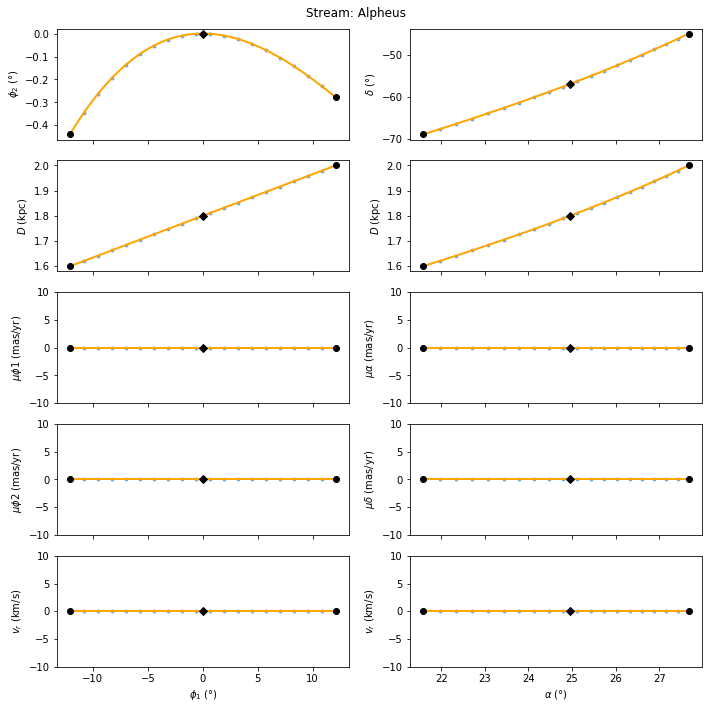

In [208]:
#Alpheus
dec=np.linspace(-69.,-45.,20)
ra = 32.116-0.00256*dec-0.00225*(dec**2)  #from Grillmair 2013
#D = 1.9*np.ones(ra.size)
zeros=np.zeros(ra.size)

Fd = scipy.interpolate.interp1d([dec[0],dec[-1]],[1.6,2.0],kind='linear',bounds_error=False)
D = Fd(dec)    #Ro,Rf are passed in kpc


Ref = "grillmair2013"
Name,ShortName= "Alpheus","Alp"

obs = ac.SkyCoord(ra=ra*u.deg, dec=dec*u.deg, distance=D*u.kpc, frame='icrs',
                 pm_ra_cosdec=zeros*u.mas/u.yr, pm_dec=zeros*u.mas/u.yr)

generate_track_from_points_plot_and_store(obs, Name, Ref, mid_point=None, ShortName=ShortName, clf=False, plot_obs=True, InfoFlags="1100")

Hermus
=======

Hermus is implemented from the polynomial fit provided by Grillmair 2014 in their Eq. 1 :

$\alpha = 241.571 + 1.37841\delta - 0.148870\delta^2 + 0.00589502\delta^3 - 1.03927\times 10^{-4}\delta^4 + 7.28133\times 10^{-7}\delta^5$


with $\delta \in [5^\circ, 50^\circ ]$ reported as the ends of the stream in their Sec. 3.1. The authors report mean heliocentric distances of 15, 20 and 19~kpc respectively for the northern ($\delta =50^\circ$), central ($\delta =40^\circ$) and southern parts ($\delta =5^\circ$) of the stream. We assume these distances to correspond to the mid-point and ends of the stream and use polynomial interpolation in between. No proper motion or radial velocity data is provided.

The Astrophysical Journal Letters, 790:L10 (5pp), 2014 July 20 doi:10.1088/2041-8205/790/1/L10 

Hermus -> track.st.Hermus.grillmair2014.ecsv


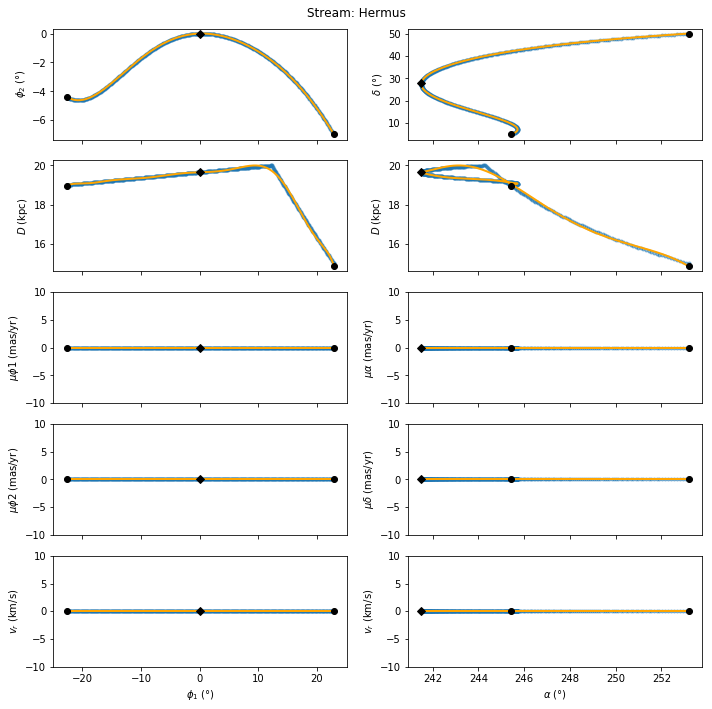

In [209]:
#Hermus
#from Grillmair 2014
N=500
dec=np.linspace(5.,+50.,500)
ra=241.571 + 1.37841*dec -0.148870*(dec**2) + 0.00589502*(dec**3) -1.03927E-4*(dec**4) + 7.28133E-7*(dec**5)
zeros=np.zeros(dec.size)
width=0.5*u.deg
#Grillmair says distance is: (15 north end, central 20, south 19) kpc
Fd = scipy.interpolate.interp1d([dec[0],40.,dec[-1]],[19.,20.,15.],kind='linear',bounds_error=False)
D = Fd(dec)    #Ro,Rf are passed in kpc

#D = 18.+zeros

Ref = "grillmair2014"
Name,ShortName= "Hermus","Her"

obs = ac.SkyCoord(ra=ra*u.deg, dec=dec*u.deg, distance=D*u.kpc, frame='fk5',
                 pm_ra_cosdec=zeros*u.mas/u.yr, pm_dec=zeros*u.mas/u.yr)

# dec=40.
# ra=241.571 + 1.37841*dec -0.148870*(dec**2) + 0.00589502*(dec**3) -1.03927E-4*(dec**4) + 7.28133E-7*(dec**5)
# D=20.
# midpnt = ac.SkyCoord(ra=ra*u.deg, dec=dec*u.deg, distance=D*u.kpc, frame='fk5')

generate_track_from_points_plot_and_store(obs, Name, Ref, mid_point=None, deg=10, ShortName=ShortName, clf=False, plot_obs=True, InfoFlags="1100")

Hyllus
=======

Hyllus is implemented from the polynomial fit provided by Grillmair 2014 in their Eq. 1 :

$\alpha = 255.8150 - 0.78364\delta + 0.01532\delta^2$

with $\delta \in [11^\circ,34^\circ]$. The limits in declination are not given explicitly in Grillmair 2014, so they were taken from the compilation in Table 4.1 of Grillmair & Carlin 2014 (newberg & Carlin review). The authors report mean heliocentric distances of 18.5 and 23~kpc respectively for the northern and southern ends of the stream. We assume these distances to correspond to the ends of the stream and use linear interpolation in between. No proper motion or radial velocity data is provided.

The Astrophysical Journal Letters, 790:L10 (5pp), 2014 July 20 doi:10.1088/2041-8205/790/1/L10 

Hyllus -> track.st.Hyllus.grillmair2014.ecsv


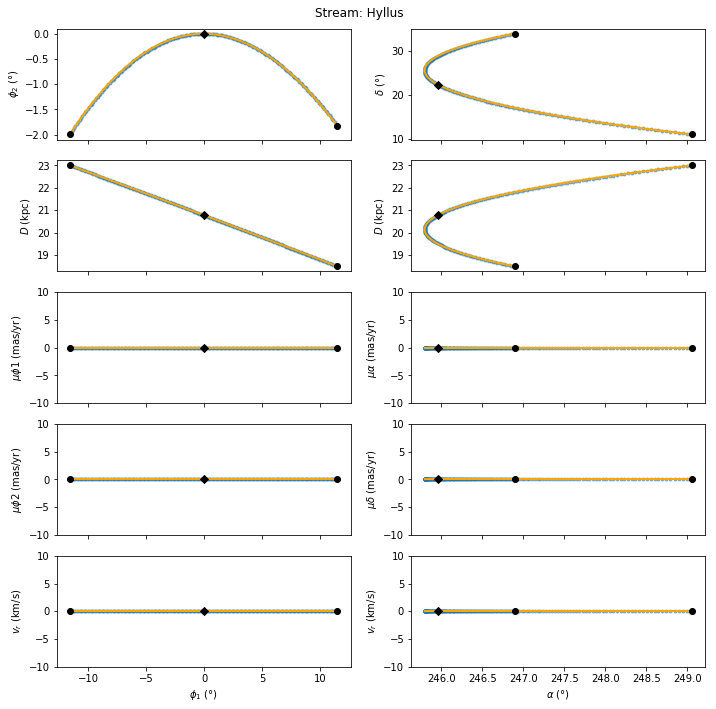

In [210]:
dec=np.linspace(11.,+34.,200)
ra=255.8150-0.78364*dec + 0.01532*dec**2
#D= north 18.5, south 23

zeros=np.zeros(ra.size)
width=0.5*u.deg
#Grillmair says distance is: (north 18.5 and 23 south) kpc
Fd = scipy.interpolate.interp1d([dec[-1],dec[0]],[18.5,23.],kind='linear',bounds_error=False)
D = Fd(dec)    #Ro,Rf are passed in kpc

Ref = "grillmair2014"
Name,ShortName= "Hyllus","Hyl"

obs = ac.SkyCoord(ra=ra*u.deg, dec=dec*u.deg, distance=D*u.kpc, frame='fk5',
                 pm_ra_cosdec=zeros*u.mas/u.yr, pm_dec=zeros*u.mas/u.yr)

generate_track_from_points_plot_and_store(obs, Name, Ref, mid_point=None, ShortName=ShortName, clf=False, plot_obs=True, InfoFlags="1100")

Murrumbidgee
===========

Murrumbidgee -> track.st.Murrumbidgee.grillmair2017b.ecsv


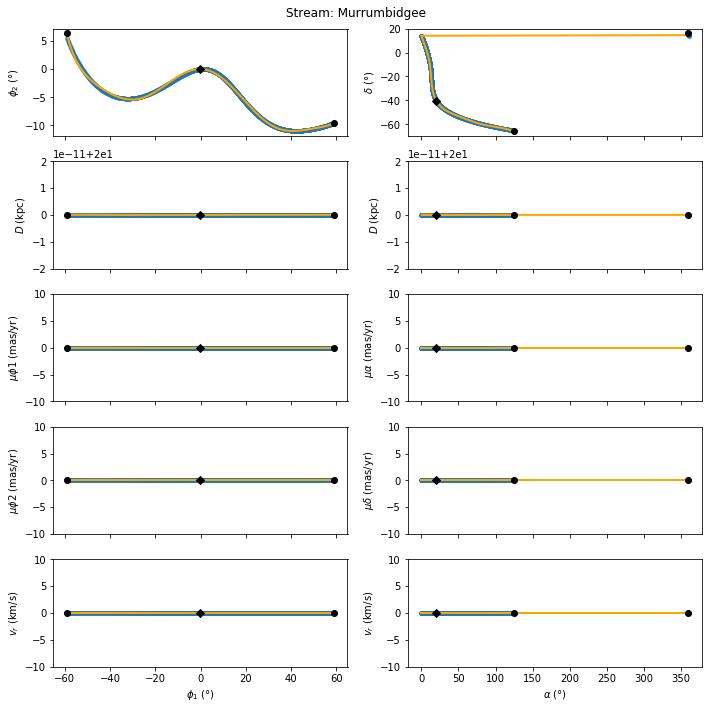

In [212]:
#Murrumbidgee, From Grillmair 2017b
dec=np.linspace(-65,+16.,3000)  
#dec range is not clear in G17's paper, the fiducial point is not included in the mentioned
#range -65<dec<-30.
#print bovyc.lb_to_radec(180.,-5.)
ra=367.893 -0.4647*dec -0.00862*dec**2 + 0.000118*dec**3 +1.2347e-6*dec**4 -1.13758e-7*dec**5
ra=ra % 360.

zeros=np.zeros(ra.size)
width=22*u.arcmin
D = 20.0+zeros

Ref = "grillmair2017b"
Name,ShortName= "Murrumbidgee","Mur"

obs = ac.SkyCoord(ra=ra*u.deg, dec=dec*u.deg, distance=D*u.kpc, frame='fk5',
                 pm_ra_cosdec=zeros*u.mas/u.yr, pm_dec=zeros*u.mas/u.yr)

generate_track_from_points_plot_and_store(obs, Name, Ref, mid_point=None, deg=8, ShortName=ShortName, clf=False, plot_obs=True, InfoFlags="1000")

43.848477192694524
-25.269756585528512 16.0
-87.91900083057439 -44.734225594908004


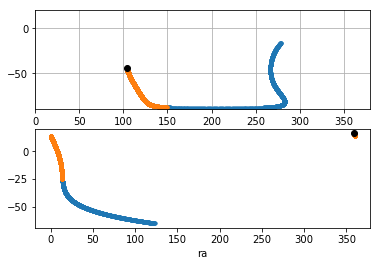

In [213]:
#Testing
mask=(-65<obs.galactic.b.deg) & (obs.galactic.b.deg<-30.)
maskl=(obs.galactic.l.deg<150.)
mask=mask & maskl
mask=maskl

fiducial = ac.SkyCoord(ra=358.614*u.deg,dec=16.274*u.deg)

plt.subplot(211)
plt.plot(obs.galactic.l,obs.galactic.b,'.')
plt.plot(obs.galactic.l[mask],obs.galactic.b[mask],'.')
plt.plot(fiducial.galactic.l,fiducial.galactic.b,'ko')
plt.xlabel('l')
plt.xlim(0.,380.)
plt.ylim(-90,20.)
plt.grid()
plt.subplot(212)
plt.plot(obs.ra,obs.dec,'.')
plt.plot(obs.ra[mask],obs.dec[mask],'.')
plt.plot(fiducial.ra,fiducial.dec,'ko')
plt.xlabel('ra')

print(obs[mask][0].separation(obs[mask][-1]).deg)
print(np.min(obs.dec[mask].deg),np.max(obs.dec[mask].deg))
print(np.min(obs.galactic.b[mask].deg),np.max(obs.galactic.b[mask].deg))

In [214]:
#End points in Riley & Strigari
#Murrumbidgee
mo=ac.SkyCoord(ra=358.71,dec=15.97,unit='deg')
mf=ac.SkyCoord(ra=13.90,dec=-25.27,unit='deg')
mo.separation(mf)

<Angle 43.81493382 deg>

Molonglo
====

Molonglo -> track.st.Molonglo.grillmair2017b.ecsv


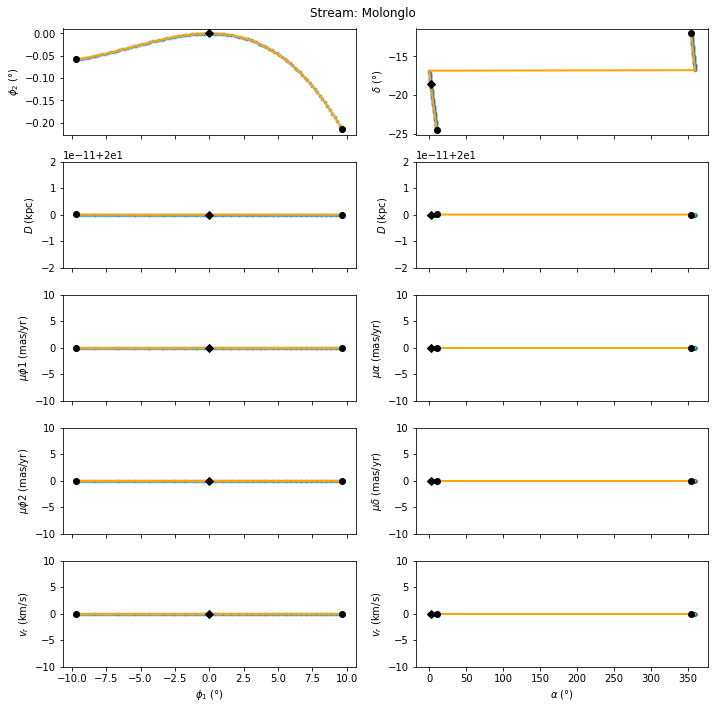

In [217]:
#Molonglo, From Grillmair 2017b
dec=np.linspace(-24.5,-12.,100) #explicitly in G17b
ra=345.017 - 0.5843*dec + 0.0182*dec**2
ra=ra % 360.

zeros=np.zeros(ra.size)
#width=0.5*u.deg
D = 20.0+zeros
#Fd = scipy.interpolate.interp1d([dec[-1],dec[0]],[18.5,23.],kind='linear',bounds_error=False)
#D = Fd(dec)*u.kpc    #Ro,Rf are passed in kpc

Ref = "grillmair2017b"
Name,ShortName= "Molonglo","Mol"

obs = ac.SkyCoord(ra=ra*u.deg, dec=dec*u.deg, distance=D*u.kpc, frame='fk5',
                 pm_ra_cosdec=zeros*u.mas/u.yr, pm_dec=zeros*u.mas/u.yr)


obs = ac.SkyCoord(ra=ra*u.deg, dec=dec*u.deg, distance=D*u.kpc, frame='fk5',
                 pm_ra_cosdec=zeros*u.mas/u.yr, pm_dec=zeros*u.mas/u.yr)

generate_track_from_points_plot_and_store(obs, Name, Ref, mid_point=None, deg=3, ShortName=ShortName, clf=False, plot_obs=True, InfoFlags="1000")

Orinoco
=====

Orinoco -> track.st.Orinoco.grillmair2017.ecsv


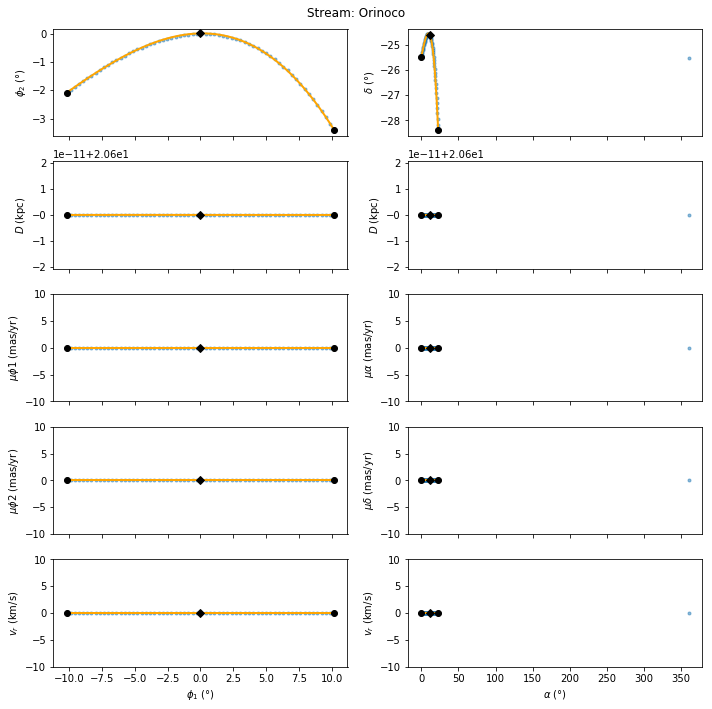

In [220]:
ra = np.linspace(0.,360.,1000)
dec = -25.5146 + 0.1672*ra -0.003827*ra**2 -0.0002835*ra**3 -5.3133e-6*ra**4
ra,dec=ra[np.abs(dec)<=90],dec[np.abs(dec)<=90]
maskb=(ra>(360-36)) | (ra<23) 
ra,dec=ra[maskb],dec[maskb]
zeros=np.zeros(ra.size)
width=40.*u.arcmin #G17b
D = 20.6+zeros #G17b
#Fd = scipy.interpolate.interp1d([dec[-1],dec[0]],[18.5,23.],kind='linear',bounds_error=False)
#D = Fd(dec)*u.kpc    #Ro,Rf are passed in kpc

Ref = "grillmair2017"
Name,ShortName= "Orinoco","Ori"

obs = ac.SkyCoord(ra=ra*u.deg, dec=dec*u.deg, distance=D*u.kpc, frame='fk5',
                 pm_ra_cosdec=zeros*u.mas/u.yr, pm_dec=zeros*u.mas/u.yr)

generate_track_from_points_plot_and_store(obs, Name, Ref, mid_point=None, ShortName=ShortName, clf=False, plot_obs=True, InfoFlags="1000")

Kwando
=====

Kwando -> track.st.Kwando.grillmair2017.ecsv


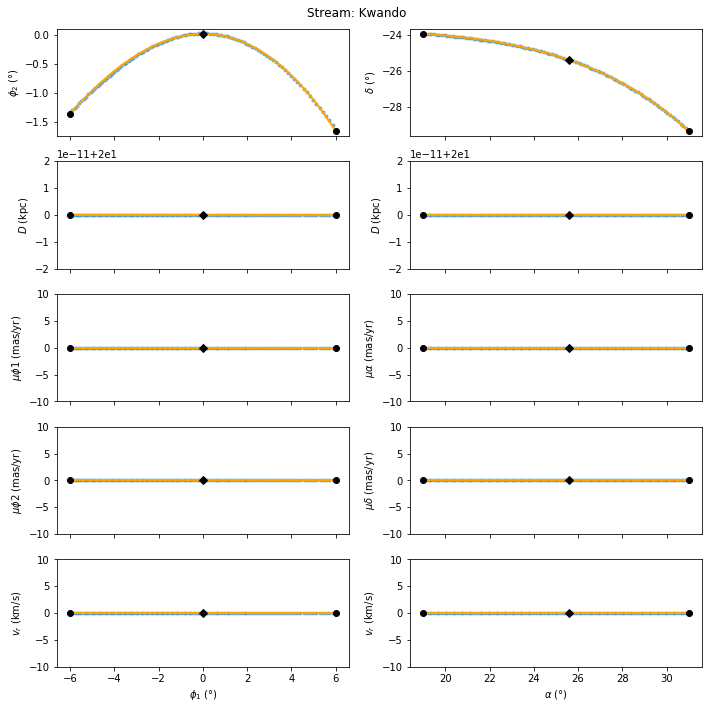

In [221]:
ra = np.linspace(19.,31.,100)
dec = -7.817 -2.354*ra +0.1202*ra**2 -0.00215*ra**3 
D=20*np.ones_like(ra)
zeros=np.zeros(ra.size)
width=22.*u.arcmin

Ref = "grillmair2017"
Name,ShortName= "Kwando","Kaw"

obs = ac.SkyCoord(ra=ra*u.deg, dec=dec*u.deg, distance=D*u.kpc, frame='fk5',
                 pm_ra_cosdec=zeros*u.mas/u.yr, pm_dec=zeros*u.mas/u.yr)

generate_track_from_points_plot_and_store(obs, Name, Ref, mid_point=None, ShortName=ShortName, clf=False, plot_obs=True, InfoFlags="1000")

Orphan
=======

The track for the Orphan stream is realised from the knots reported in Tables C1-C3 Koposov2019 for the sky, distance and pm_phi1 track. These were derived by fitting Gaia DR2 data for RR Lyrae stars selected as stream candidates with simple tangential velocity and XX filters and are reported after having been corrected for the solar reflex motion. We subtract the correction in order to report the raw, directly observable proper motions, consistently throughtout the library. The pm_phi2 corresponds to that in Fig.~1 of Erkal2019. Koposov2019 report in their Table 4 radial velocities from SDSS spectroscopic observations, corrected for the solar reflex motion (i.e. VGSR). As with the proper motions, we add back the solar reflex term to the radial velocities, assuming the solar paramters used by Koposov2019 for the corrections (CHECK This, Schoenrich & Binney?) to report all data in the heliocentric frame.  

*vrad are not implemented yet because I need to figure our how to block out the parts were no data is available.*

pm_phi2 in the plot is not zero because the auto-computed stream frame is not identical to the original frame in which pm_phi2 was zero.

The stream frame adopted is the one reported in Koposov2019. 

NOTE: Pass user defined midpoint: Same as for the mid_point.

Step 1:
----

Do polyfits on the RRL data provided in Koposov2019. This was necessary to derive the pm_phi2 track, which is not given in K19 or in Erkal2019. 
The auto-computed track was checked against the splines provided by K19 used below and the match is nearly perfect. Either one could be used.


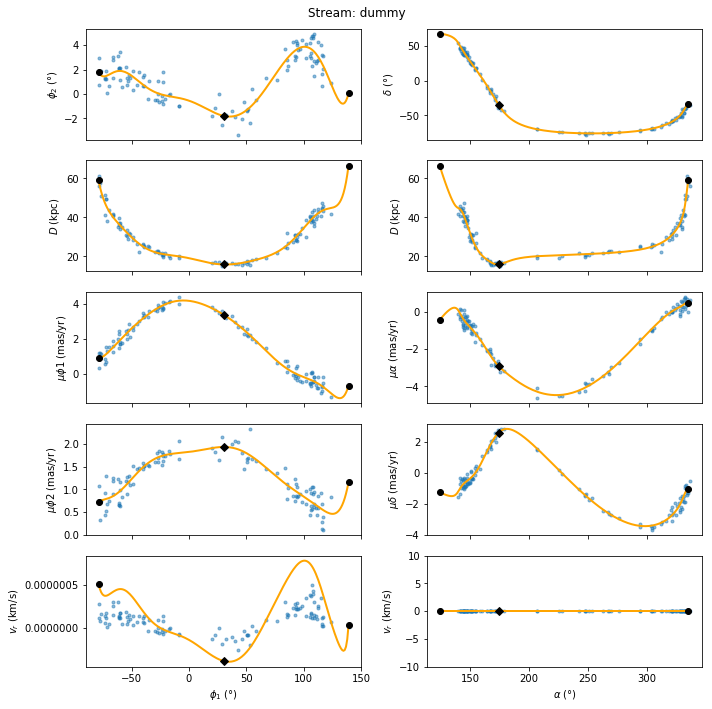

In [222]:
#The pmphi2 track is not available so I'll have to get it from the RRL data
rrs=pd.read_csv("/Users/cmateu/trabajo/research/aspen_orphan/orphan_rrl_members.alldata.csv")

obs = ac.SkyCoord(ra=np.array(rrs.RA)*u.deg, dec=np.array(rrs.DEC)*u.deg, distance=np.array(rrs.DIST)*u.kpc, frame='icrs', 
                  pm_ra_cosdec=np.array(rrs.pmra)*u.mas/u.yr, pm_dec=np.array(rrs.pmdec)*u.mas/u.yr, radial_velocity=np.zeros(rrs.DIST.size)*u.km/u.s)

#Rotation matrix from Koposov+ 2019 appendix
Mrot_radec_to_phi12=[[-0.44761231,-0.08785756,-0.88990128],
                     [-0.84246097,0.37511331,0.38671632],
                     [0.29983786,0.92280606,-0.2419219]]

stream_frame = gc.GreatCircleICRSFrame.from_R(Mrot_radec_to_phi12)


rrtrack=generate_track_from_points_plot_and_store(obs, "dummy", "dummy", mid_point=None, deg=10, ShortName="dummy", clf=False, do_not_store=True,
                                                  plot_obs=True, stream_frame=stream_frame, return_track=True)

#Here I just compute the pmphi2 track, that's why it's not saved yet.

Step 2:
----

Below we construct the tracks using the spline knots provided by K19. The pmphi1 track (and vrad track where available) were added the solar reflex motions, as these tracks were already corrected by it. Note that, for the track to be complete, the pm_phi2 track used is the auto-computed in the previous cell using the RRLs from the same paper.

Orphan -> track.st.Orphan.koposov2019.ecsv


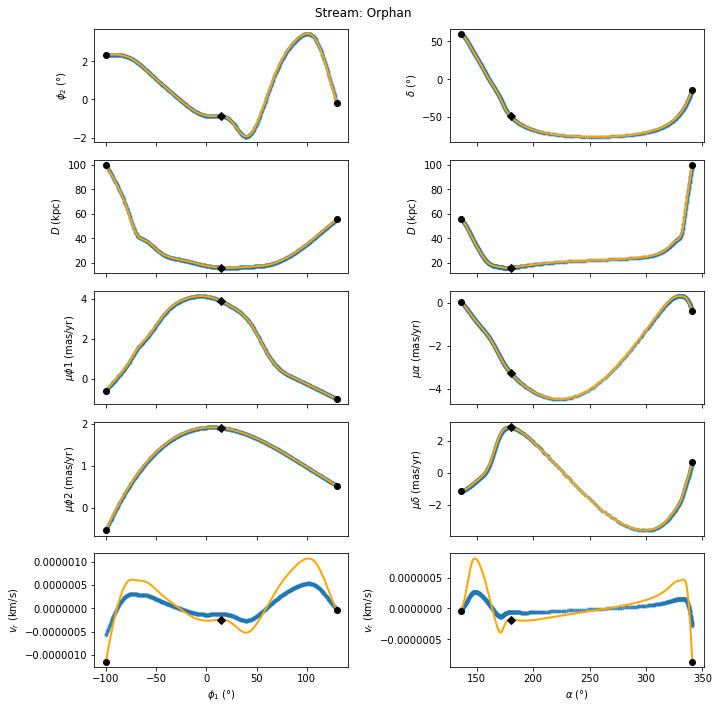

In [226]:
#Orphan footprint from Koposov et al. 2019 - Gaia DR2 RRLs. sky, distance and muphi1 tracks are from Tables C1-C3.

#Rotation matrix from Koposov+ 2019 appendix
Mrot_radec_to_phi12=[[-0.44761231,-0.08785756,-0.88990128],
                     [-0.84246097,0.37511331,0.38671632],
                     [0.29983786,0.92280606,-0.2419219]]

stream_frame = gc.GreatCircleICRSFrame.from_R(Mrot_radec_to_phi12)

#Knots for D(phi1) interpolation
phi1_Dknot=np.array([-100.0,-76.2169,-69.9684,-63.1307,-44.2712,-25.0268,-5.3975,20.0052,42.3287,61.958,90.0548,114.3027])   
Dknot=np.array([100.0,58.0,44.0,39.441,27.6252,22.5353,18.7178,15.9911,16.9,18.5361,29.2612,44.8945])
#phi1-phi2
#Knots for phi2(phi1) stream track interpolation
phi1k=np.array([-105.186,-74.7184,-54.4067,-25.4375,0.2019,25.8413,39.1605,66.9643,93.1032,108.0872,129.8974,162.5293])
phi2k=np.array([2.315,2.148,1.2797,-0.0562,-0.8577,-1.1917,-1.9598,1.1127,3.2835,3.2167,-0.1564,-4.8653])
#Interpolators
orphan_Dspline=scipy.interpolate.CubicSpline(phi1_Dknot,Dknot,bc_type='natural',extrapolate=True)
orphan_phi2spline=scipy.interpolate.CubicSpline(phi1k,phi2k,bc_type='natural')

#Pmphi1 interpolator
phi1_mu1_knots=[]
phi2_mu1_knots=[]

x=np.array([-77.4458, 0.0408, -49.626, 1.3103, -28.3432, 2.3325, -2.1956, 3.1889, 24.2559, 3.881, 44.0186, 3.9108, 65.9096, 2.6219, 88.4086, 1.569, 103.6106, 
          0.8984, 124.7415, 0.0051])
phi1_mu1_knots=x[::2]
phi2_mu1_knots=x[1::2]
orphan_muphi1_spline=scipy.interpolate.CubicSpline(phi1_mu1_knots,phi2_mu1_knots,bc_type='natural',extrapolate=True)

#Knots for pmphi2 are not given in Koposov2019 or Erkal2019. This is a polynomial fit of the data for the RRLs (see previous cell)
pm_phi2_fit=np.poly1d(np.polyfit(rrtrack.transform_to(stream_frame).phi1.deg,rrtrack.transform_to(stream_frame).pm_phi2.value, deg=3))

#VGSR - Table 4 - Kposov2019
tt=[50, 35.097 , 67, 91.084 , 77, 111.054 , 85, 121.997 , 95, 132.123 , 105, 132.763 , 115, 116.263 , 120, 103.205]
phi1_vgsr=tt[::2]
vgsr=tt[1::2]
vgsr_spline = np.poly1d(np.polyfit(phi1_vgsr,vgsr, deg=3))

#Plot to check
phi1s=np.linspace(-100,130,500)
Ds=orphan_Dspline(phi1s)
phi2s=orphan_phi2spline(phi1s)
muphi1s=orphan_muphi1_spline(phi1s)
muphi2s=pm_phi2_fit(phi1s)
vgsrs= vgsr_spline(phi1s)
zeros=np.zeros(phi1s.size)


#Solar reflex motion contribution in stream coords
zz = ac. SkyCoord(phi1=phi1s*u.deg, phi2=phi2s*u.deg, distance=Ds*u.kpc,
                  pm_phi1_cosphi2=zeros*u.mas/u.yr, 
                  pm_phi2=zeros*u.mas/u.yr, radial_velocity=zeros*u.km/u.s, 
                  frame=stream_frame)
sun_reflex = gc.reflex_correct(zz,galactocentric_frame=ac.Galactocentric(galcen_distance=8.34*u.kpc, galcen_v_sun=(11.1,240.+12.24,7.25)*u.km/u.s) )

coo = ac.SkyCoord(phi1=phi1s*u.deg, phi2=phi2s*u.deg, distance=Ds*u.kpc, frame=stream_frame)
#Sun's peculiar velocity from Schönrich, R., Binney, J., & Dehnen, W. 2010, MNRAS, 403, 1829. 
#VLSR=240 and Rsun=8.34kpc from Reid, M. J., Menten, K. M., Brunthaler, A., et al. 2014, ApJ, 783, 130
vhel = gc.vgsr_to_vhel(coordinate=coo.galactic, vgsr=vgsrs*u.km/u.s, vsun=(11.1,240.+12.24,7.25)*u.km/u.s)  #just to check sun_reflex correction

#radial velocity is only valid in range phi=[50,120]
m = (phi1s<50) | (phi1s>120)
vhel[m] =0*u.km/u.s


#Build the track after having removed the solar reflex correction in pm_phi1 (pm_phi2 comes from a diff source, it was not corrected)
stream_track = ac.SkyCoord(phi1=phi1s*u.deg, phi2=phi2s*u.deg, distance=Ds*u.kpc, frame=stream_frame,
                           pm_phi1_cosphi2=muphi1s*u.mas/u.yr -sun_reflex.pm_phi1_cosphi2, 
                           pm_phi2=muphi2s*u.mas/u.yr, #does not have solar reflex correction, its from a different source
                           radial_velocity=zeros*u.km/u.s)
#                           radial_velocity=vhel)


Ref = "koposov2019"
Name,ShortName= "Orphan","Orp"


ftrack=generate_track_from_points_plot_and_store(stream_track.icrs, Name, Ref, deg=30, mid_point=None, ShortName=ShortName, 
                                                  clf=False, plot_obs=True, stream_frame=stream_frame, return_track=True, InfoFlags="1111" )

This is a consistency check to make sure th tracks constructed from the splines (and solar reflex un-corrected) match the raw poly fits obtained from the RRLs. They do. Yay me.

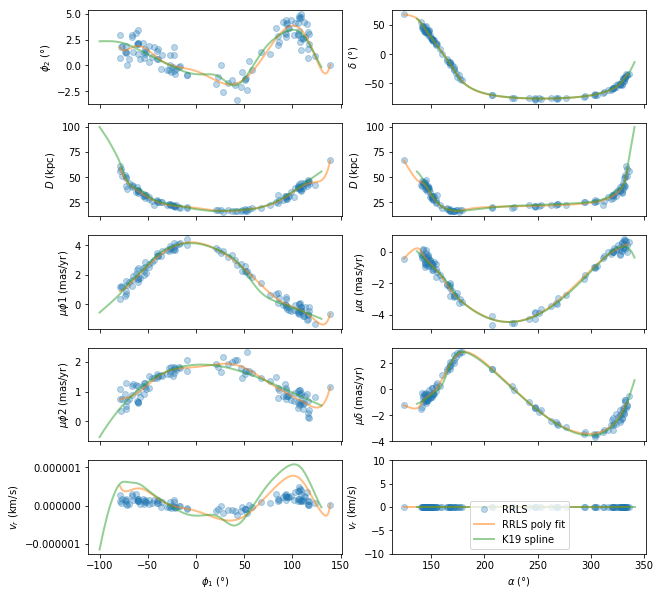

In [224]:
nx, ny = 2, 5
fig=plt.figure(1,figsize=(10,10))
axs = fig.subplots(ny,nx, sharex="col")

stream_plot_card(obs, stream_frame, axs, plotkwds=dict(marker='o',ls='', alpha=0.3, label='RRLS'))
stream_plot_card(rrtrack, stream_frame, axs, plotkwds=dict(ls='-', lw=2, alpha=0.5, label='RRLS poly fit'))
stream_plot_card(ftrack, stream_frame, axs, show_labels=True, plotkwds=dict(ls='-', lw=2, alpha=0.5, label='K19 spline'))

plt.legend()

In [225]:
#plt.plot(sun_reflex.phi1, vhel-(vgsrs*u.km/u.s - sun_reflex.radial_velocity),'.')

Tri-Pis (Triangulum stream Bonaca et al. 2012)
===


Tri-Pis -> track.st.Tri-Pis.bonaca2012.ecsv


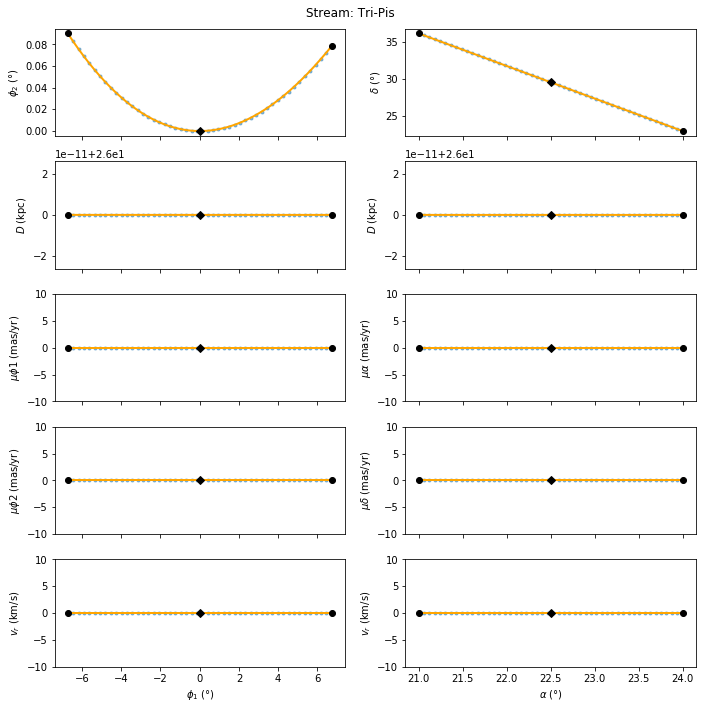

In [227]:
#DEC = 4.4*RA + 128.5; with 21<RA>24
#Bonaca2012 mean distance adopted for the stream
ra=np.linspace(21,24,50)
dec = -4.4*ra + 128.5
D = 26.*np.ones(ra.size)
width=0.2*u.deg
zeros=np.zeros(ra.size)

Ref = "bonaca2012"
Name,ShortName= "Tri-Pis","TriPis"

obs = ac.SkyCoord(ra=ra*u.deg, dec=dec*u.deg, distance=D*u.kpc, frame='fk5',
                 pm_ra_cosdec=zeros*u.mas/u.yr, pm_dec=zeros*u.mas/u.yr)

generate_track_from_points_plot_and_store(obs, Name, Ref, mid_point=None, ShortName=ShortName, clf=False, plot_obs=True, InfoFlags="1000")


NGC5466
====

#Old realization
#Middle point  are central coords of NGC5466 from Harris1997 (2010ed),
#Heliocentric distance also from Harris1997 (2010ed)
#Stream end points are from Grillmair & Johnson 2006, Fig 1 caption

Initially detected by Belokurov et al. 2006 (https://iopscience.iop.org/article/10.1086/500362/pdf) within $\sim3^\circ$ of the cluster center. Later photometric follow-up by Grillmair & Johnson 2006 revealed  tails of XX longitude.

Current realization: Points were read-off of figure 2 of Grillmair & Johnson 2006 following the dot-dashed line as a guide. Extraction made with WebPlotDigitizer (https://apps.automeris.io/wpd/)

Interesting to note that Weiss et al. 2018 report three detections near but about $\sim 5^\circ$ south of the NGC5466 stream reported by Grillmair & Johnson 2006 (see utility plot below)

NGC5466 -> track.st.NGC5466.grillmair2006.ecsv


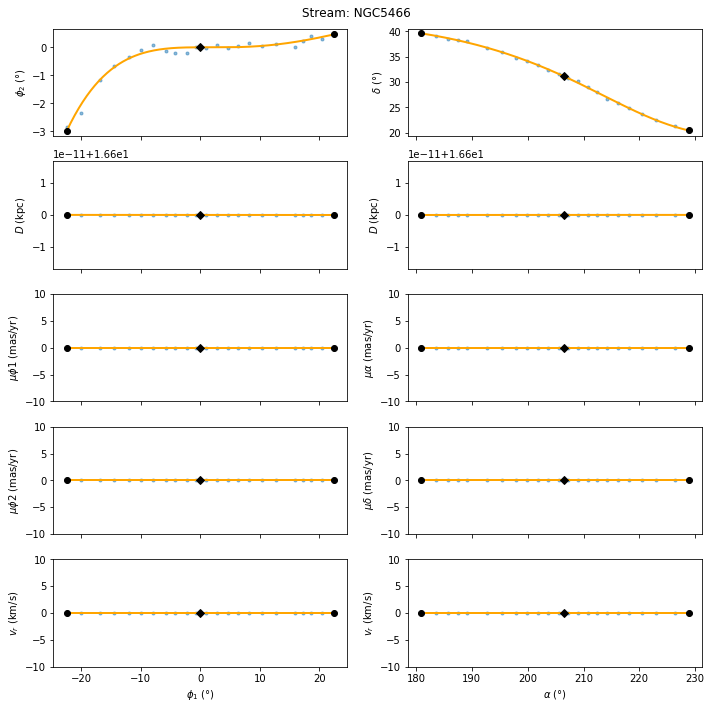

In [228]:
#RA     DEC     D     Center
#180.    42.     16.6  0
#211.36  28.53   16.6  1
#228.    21.     16.6  0
# ra = np.array([180.,211.36,228.])
# dec = np.array([42., 28.53, 21.])
# D = 16.6*np.ones(ra.size)
# zeros=np.zeros(ra.size)

tr = np.array([228.73, 20.34, 226.45, 21.43, 222.97, 22.52, 220.51, 23.61, 218.12, 24.81, 216.12, 25.78, 214.18, 26.76, 212.35, 28.13, 
               210.81, 29.10, 208.93, 30.13, 207.22, 30.76, 205.68, 31.56, 203.68, 32.42, 201.80, 33.40, 
               199.86, 34.14, 197.86, 34.83, 195.46, 35.86, 192.72, 36.77, 189.07, 38.03, 187.42, 38.26, 185.76, 38.55, 183.54, 39.18, 180.91, 39.58])
ra,dec = tr[::2],tr[1::2]
D = 16.6*np.ones(ra.size)
zeros=np.zeros(ra.size)

Ref = "grillmair2006"
Name,ShortName= "NGC5466","NGC5466"

obs = ac.SkyCoord(ra=ra*u.deg, dec=dec*u.deg, distance=D*u.kpc, frame='fk5',
                 pm_ra_cosdec=zeros*u.mas/u.yr, pm_dec=zeros*u.mas/u.yr)

generate_track_from_points_plot_and_store(obs, Name, Ref, deg=5, mid_point=None, ShortName=ShortName, clf=False, plot_obs=True, InfoFlags="1000")



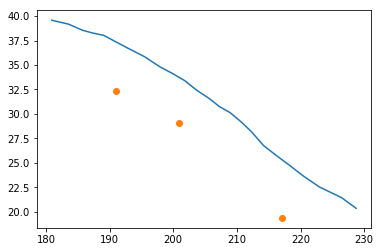

In [229]:
plt.plot(obs.ra, obs.dec,'-')
l=[18.8,49.7,140.2]
b=[66.5,82.6,84.5]
w = ac.SkyCoord(l=l,b=b,unit=u.deg,frame='galactic')
plt.plot(w.icrs.ra,w.icrs.dec,'o')

Cetus or Cetus Polar Stream
====
Yanny, B., Newberg, H. J., Johnson, J. A., et al. 2009, ApJ, 700, 1282

Newberg, H. J., Yanny, B., & Willett, B. A. 2009, ApJ, 700, L61

Discovered by Yanny et al. 2009 and confirmed as an overdensity near the Sgr trailing by Newberg et al. 2009 using SEGUE.
Yam et al. 2013 follo-up and provide a sky, distance and radial velocity track (5 points reported in Table 1)

Yam et al. report the measured radial velocities in the GSR. The authors do not explicitly state the solar parameters assumed to convert the observed radial velocities to the GSR. To revert back to the heliocentric frame and compute the observed radial velocity we assume $(U,V,W)=(10.3,232.6,5.9)$~km/s from Schoenrich & Binney 2010, available and widely used at the time.

Cetus -> track.st.Cetus.yam2013.ecsv


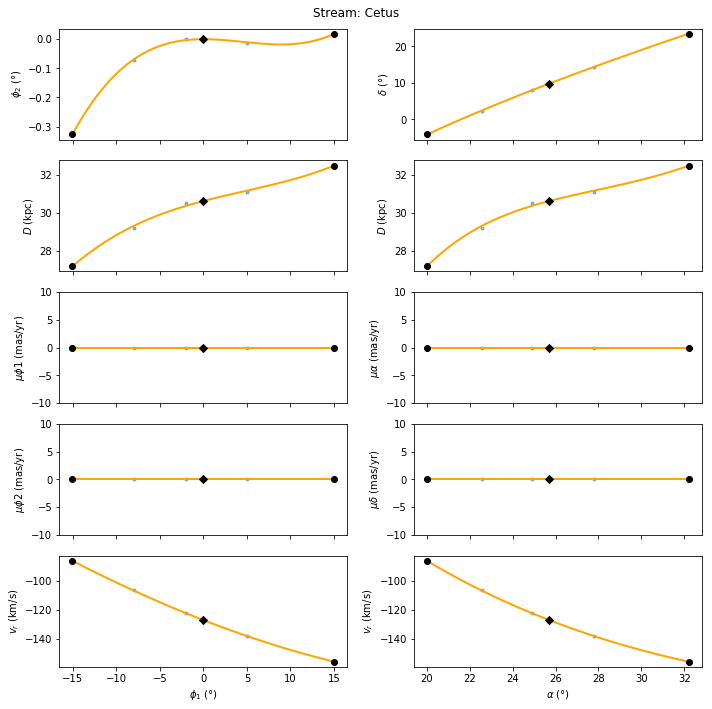

In [230]:
#Galstreams 1 table had l vector flipped.
#Table 1 from Yam et al. 2013. For b we take the middle of the range reported in the table
tr = np.array([140.7,  -66, 27.2, 142.,  -59., 29.2, 143.,  -53., 30.5, 144.,  -46., 31.1, 145.,  -36., 32.5])
l, b, D = tr[::3],tr[1::3],tr[2::3]
Vgsr = np.array([-35.2, -42.2, -47.8, -53.0, -57.9])
zeros=np.zeros(l.size)

Ref = "yam2013"
Name,ShortName= "Cetus","Cet"

obs = ac.SkyCoord(l=l*u.deg, b=b*u.deg, distance=D*u.kpc, frame='galactic')

#Convert Vgsr back to heliocentric, using Schoenrich & Binney 2010. This is a guess. This is not explicitly mentioned in Yam et al. 2013.
vhel = gc.vgsr_to_vhel(coordinate=obs,vgsr=Vgsr*u.km/u.s,vsun=(10.3,232.6,5.9)*u.km/u.s)

obs = ac.SkyCoord(l=l*u.deg, b=b*u.deg, distance=D*u.kpc, frame='galactic',
                 pm_l_cosb=zeros*u.mas/u.yr, pm_b=zeros*u.mas/u.yr, radial_velocity=vhel)


generate_track_from_points_plot_and_store(obs.icrs, Name, Ref, deg=3, mid_point=None, ShortName=ShortName, clf=False, plot_obs=True, InfoFlags="1100")


**300S = The 300 km/s stream**
================================================


First discovered by simon et al. 2011 who noted an excess of stars with a heliocentric radial velocity of 300km/s in a field towards Segue 1, suggesting that due to their extension they must belong to a stream. Later confirmed by Bernard et al. 2016 with PS1 data / Further follow-up to indentify the photometric counterpart was done by Niederste-Ostholt et al. (2009) wtih SDSS and Bernard et al. 2016 PS1, tracing the feature over the range $144<RA<168$. Fu2018 conducts spectroscopic follow-up with APOGEE-2 and SEGUE data.

The stream sky, distance and radial velocity tracks are taken from the orbit fit provided by Fu2018 in their Figure 10. Note that, the stream members observed and confirmed spectroscopically by Fu2018 and, thus, the orbital fit gives a sky track that differs slightly from the one reported by B16. At both ends the B16 track is a bit south of the one in Fu2018. F18 also notes the B16 track extends further than theirs, they restrict the track to the area where the stream is most prominent.

300S -> track.st.300S.fu2018.ecsv


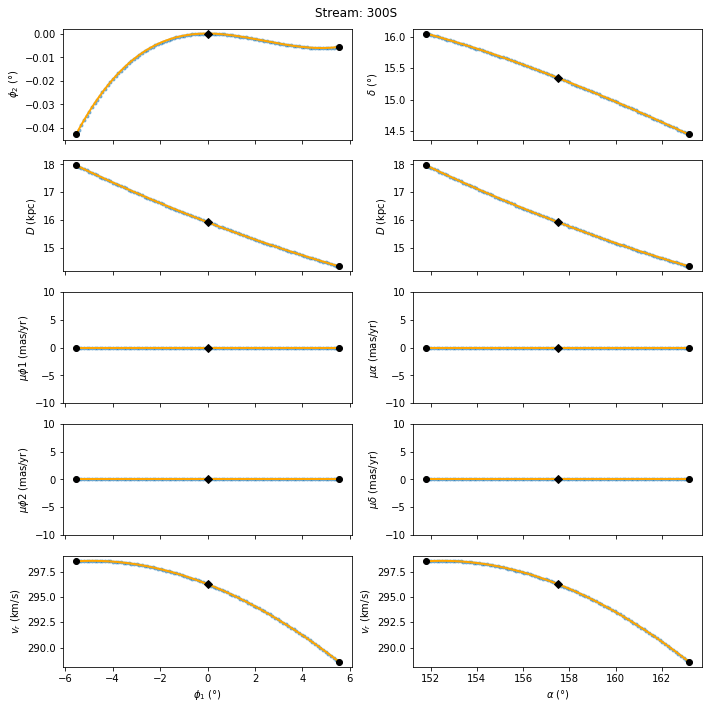

In [232]:
tr = [163.86, 14.33, 162.25, 14.60, 160.97, 14.83, 159.65, 15.01, 158.70, 15.16, 157.83, 15.31, 156.94, 15.43, 
       155.89, 15.55, 155.05, 15.68, 154.25, 15.78, 153.41, 15.88, 152.75, 15.96, 151.77, 16.04, 150.81, 16.14]
ra,dec = tr[::2][::-1],tr[1::2][::-1]
dec_spline = np.poly1d(np.polyfit(ra,dec, deg=3))

tr = [163.42, 288.04, 162.80, 289.35, 161.76, 291.03, 160.42, 292.90, 159.00, 294.77, 157.60, 296.07, 154.86, 298.13, 153.38, 298.50, 151.80, 298.50]
ra, vrad = tr[::2][::-1],tr[1::2][::-1]
vrad_spline = np.poly1d(np.polyfit(ra,vrad, deg=3))

tr = [163.17, 14.37, 161.86, 14.64, 160.20, 15.12, 158.54, 15.64, 156.71, 16.18, 155.11, 16.74, 153.86, 17.17, 152.69, 17.60, 151.80, 17.98]
ra, dist = tr[::2][::-1],tr[1::2][::-1] 
D_spline = np.poly1d(np.polyfit(ra,dist, deg=3))

#interpolate
ras=np.linspace(np.min(ra),np.max(ra),100)
decs = dec_spline(ras)
Ds = D_spline(ras)
vrads = vrad_spline(ras)
zeros=np.zeros(ras.size)

Ref = "Fu2018"
Name,ShortName= "300S","300S"

obs = ac.SkyCoord(ra=ras*u.deg, dec=decs*u.deg, distance=Ds*u.kpc, frame='fk5',
                  pm_ra_cosdec=zeros*u.mas/u.yr, pm_dec=zeros*u.mas/u.yr, radial_velocity=vrads*u.km/u.s)


generate_track_from_points_plot_and_store(obs.icrs, Name, Ref, deg=3, mid_point=None, ShortName=ShortName, clf=False, plot_obs=True, InfoFlags="1101")



Parallel stream
================

Discovered by Sohn et al. 2016. Track from Weiss et al. 2018 Table 2.

Parallel -> track.st.Parallel.weiss2018.ecsv


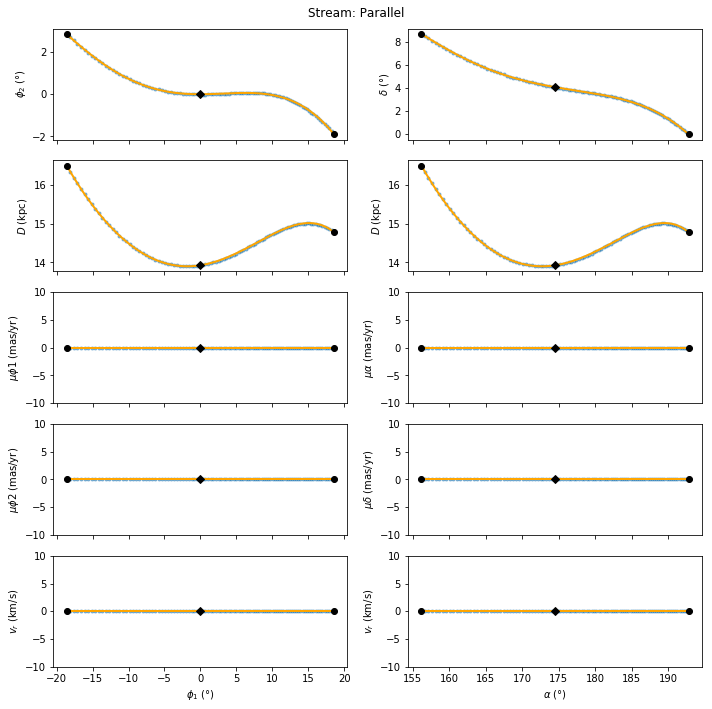

In [233]:
l = [302.8, 288.0, 253.7, 233.9]
b = [62.9, 64.6, 58.4, 50.8]
D = [14.8, 14.9, 14.0, 16.5]

b_fit = np.poly1d(np.polyfit(l,b, deg=3))
D_fit = np.poly1d(np.polyfit(l,D, deg=3))

ls = np.linspace(np.min(l),np.max(l),100)
bs = b_fit(ls)
Ds = D_fit(ls)

zeros=np.zeros(ls.size)

Ref = "Weiss2018"
Name,ShortName= "Parallel","Par"

obs = ac.SkyCoord(l=ls*u.deg, b=bs*u.deg, distance=Ds*u.kpc, frame='galactic',
                 pm_l_cosb=zeros*u.mas/u.yr, pm_b=zeros*u.mas/u.yr)


generate_track_from_points_plot_and_store(obs.icrs, Name, Ref, deg=5, mid_point=None, ShortName=ShortName, clf=False, plot_obs=True, InfoFlags="1100")



Perpendicular Stream - Weiss et al. 2018
====
Discovered by Sohn et al. 2016 or by Weiss? The latter says if confirmed would be a new discovery. Track from Weiss et al. 2018 Table 2

Perpendicular -> track.st.Perpendicular.weiss2018.ecsv


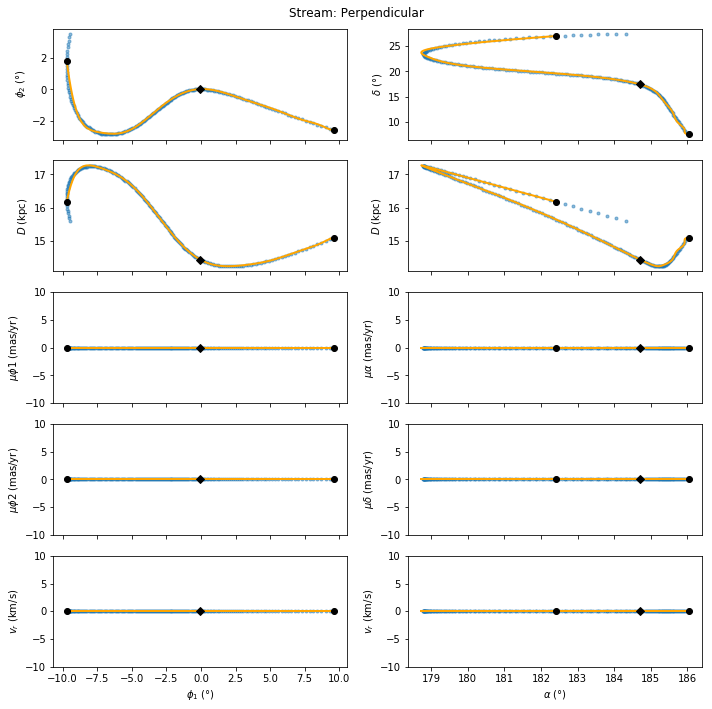

In [234]:
l = [283.4, 276.4, 245.4, 208.2]
b = [69.3, 73.8, 77.5, 82.4]
D = [15.1, 14.4, 16.0, 15.6]

b_fit = np.poly1d(np.polyfit(l,b, deg=3))
D_fit = np.poly1d(np.polyfit(l,D, deg=3))

ls = np.linspace(np.min(l),np.max(l),200)
bs = b_fit(ls)
Ds = D_fit(ls)

zeros=np.zeros(ls.size)

Ref = "Weiss2018"
Name,ShortName= "Perpendicular","Per"

obs = ac.SkyCoord(l=ls*u.deg, b=bs*u.deg, distance=Ds*u.kpc, frame='galactic',
                 pm_l_cosb=zeros*u.mas/u.yr, pm_b=zeros*u.mas/u.yr)


generate_track_from_points_plot_and_store(obs.icrs, Name, Ref, deg=13, mid_point=None, ShortName=ShortName, clf=False, plot_obs=True, InfoFlags="1100")

Pegasus stream - Perottoni et al. 2019
====

We take the end points explicitly reported by Perottoni et al. 2019 in Table 1 and add a few manually selected points off of Figure 2 (to avoid assuming the track is well aproximated by a great circle). The authors report a single heliocentric distance of 18~kpc for the full stream.

Pegasus -> track.st.Pegasus.perottoni2019.ecsv


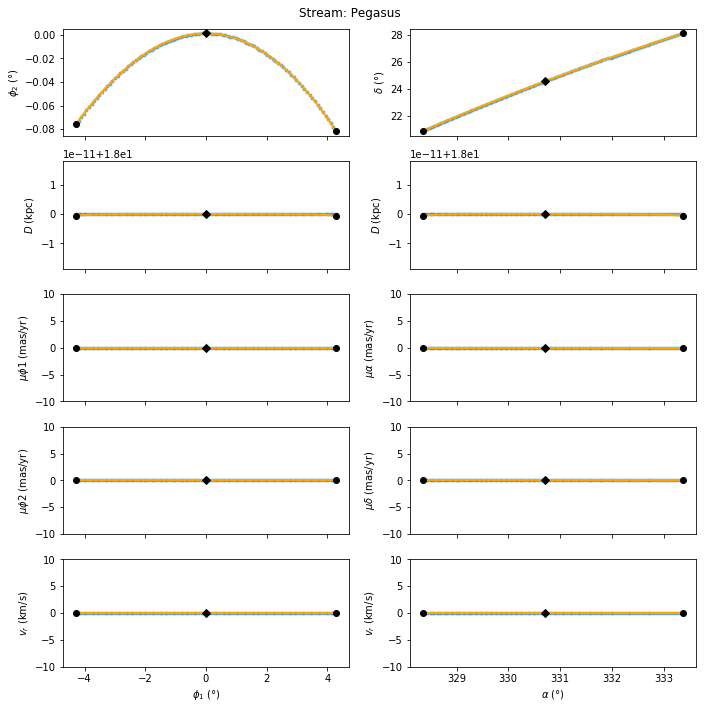

In [236]:
# ep_l = [76.4, 85.4]
# ep_b = [-25.5, -23.0]

tr = [76.4, -25.5, 79.35, -24.65, 81.00, -24.26, 82.66, -23.72, 83.63, -23.49, 85.4, -23.0]
l = tr[::2]
b = tr[1::2]
width = 0.4*u.deg

b_fit = np.poly1d(np.polyfit(l,b, deg=3))

ls = np.linspace(np.min(l),np.max(l),100)
bs = b_fit(ls)
Ds = 18.*np.ones(ls.size)
zeros=np.zeros(ls.size)

Ref = "Perottoni2019"
Name,ShortName= "Pegasus","Peg"

obs = ac.SkyCoord(l=ls*u.deg, b=bs*u.deg, distance=Ds*u.kpc, frame='galactic',
                 pm_l_cosb=zeros*u.mas/u.yr, pm_b=zeros*u.mas/u.yr)


generate_track_from_points_plot_and_store(obs.icrs, Name, Ref, deg=13, mid_point=None, ShortName=ShortName, clf=False, plot_obs=True, InfoFlags="1000")

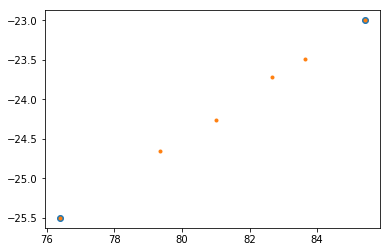

In [237]:
#to ensure continuity with end points
ep_l = [76.4, 85.4]
ep_b = [-25.5, -23.0]
plt.plot(ep_l,ep_b,'o')
plt.plot(l,b,'.')

M5 - Grillmair 2019
===

The tail is identified using a modified matched filter that weights the star's by how close they are to the predicted orbit for M5 using the cluster's Gaia DR2 proper motion. No figure shows observed data for the stream's candidate stars (they do show the orbit prediction) but the candidates (and weights) are reported in Table 1.
They have taken the cluster' proper motion from Gaia Collab 2018b. There's no information on how the solar reflex motion was subtracted.

We do not include velocity or distance track info as it would not correspond to a fit of the observations, but basically the orbital model prediction. 

M5 -> track.st.M5.grillmair2019.ecsv


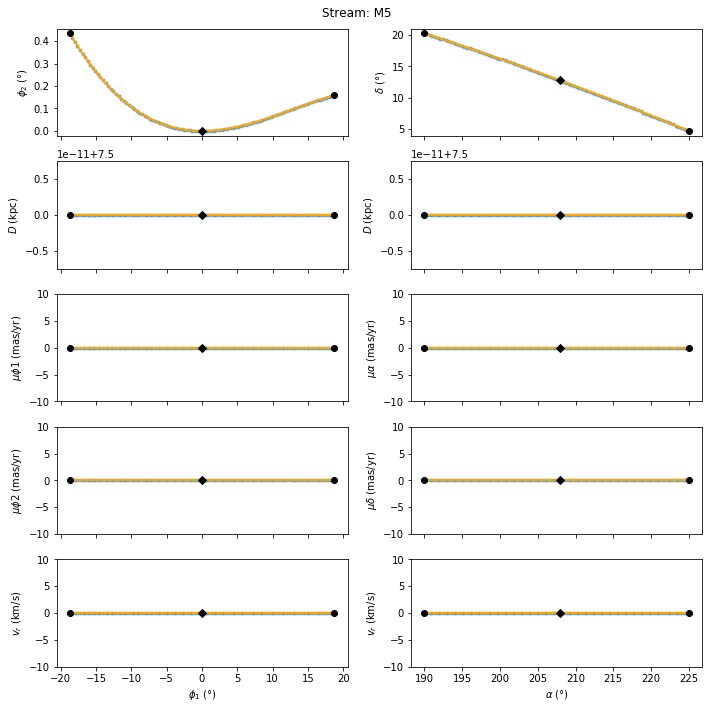

In [238]:
ra = np.linspace(190.,225.,100)
dec = 37.4026 + 0.2096*ra -0.001578*ra**2
zeros=np.zeros(ra.size)
D = 7.5*np.ones(ra.size)

Ref = "Grillmair2019"
Name,ShortName= "M5","M5"

obs = ac.SkyCoord(ra=ra*u.deg, dec=dec*u.deg, distance=D*u.kpc, frame='fk5',
                  pm_ra_cosdec=zeros*u.mas/u.yr, pm_dec=zeros*u.mas/u.yr, radial_velocity=zeros*u.km/u.s)


generate_track_from_points_plot_and_store(obs.icrs, Name, Ref, deg=3, mid_point=None, ShortName=ShortName, clf=False, plot_obs=True, InfoFlags="1000")




M68
====

Palau & Miralda-Escudé 2018. Very similar procedure to that of Grillmair 2019 (this is an internal note). 

We use the stream candidate data reported in their Table E1 to derive the 5D track by polynomial fitting. The distance track is computed assuming 1/parallax as a distance estimator and excising stars with negative parallaxes and parallaxes < 1/20 which are clear outliers.

M68 -> track.st.M68.palau2019.ecsv


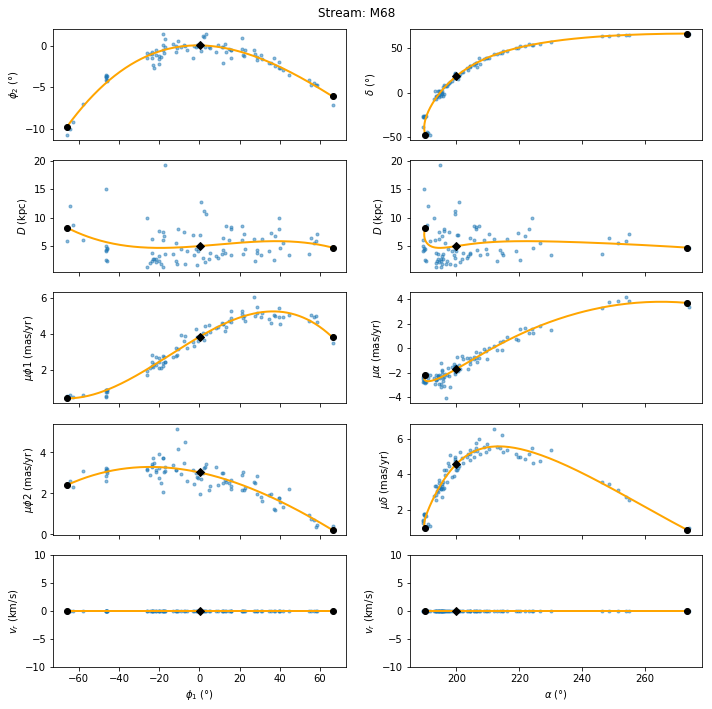

In [239]:
tt = astropy.io.ascii.read("../support_data/tableE1.palau2019.m68.csv",format='csv')
tt = tt[ (tt["parallax"]>0) & (1./tt['parallax']<20.)]

obs = ac.SkyCoord(ra=tt["ra"]*u.deg, dec=tt["dec"]*u.deg, distance=1./tt["parallax"]*u.kpc, 
                 pm_ra_cosdec=tt["muracosdec"]*u.mas/u.yr, pm_dec=tt["mudec"]*u.mas/u.yr, frame='icrs')

Ref = "Palau2019"
Name,ShortName= "M68","M68"


generate_track_from_points_plot_and_store(obs.icrs, Name, Ref, deg=3, mid_point=None, ShortName=ShortName, clf=False, plot_obs=True, InfoFlags="1110")



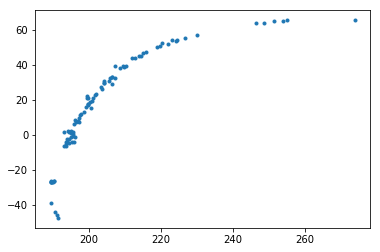

In [240]:
plt.plot(tt["ra"],tt["dec"],'.')

NGC3201
=====

Palau & Miralda-Escudé 2020. Mention that Gjoll is a section of the NGC3201 tails

/Users/cmateu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


NGC3201 -> track.st.NGC3201.palau2020.ecsv


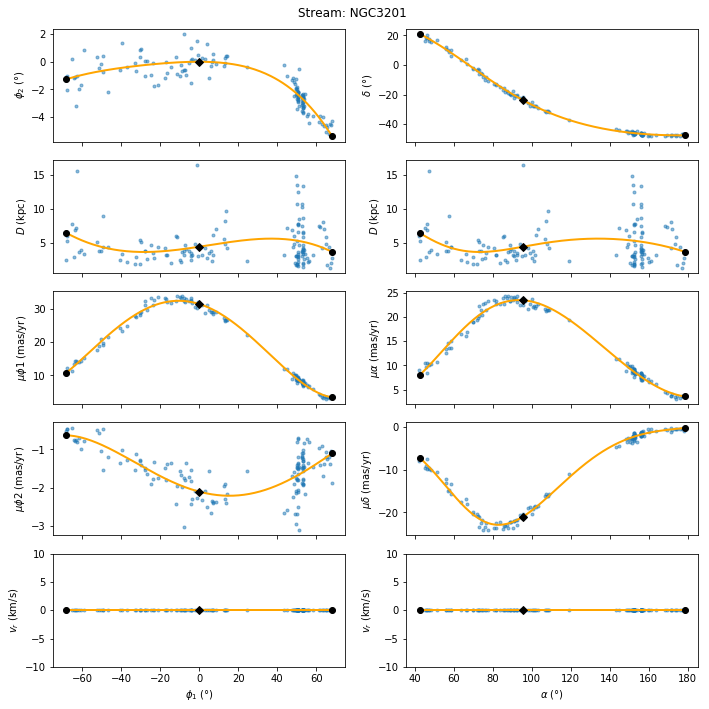

In [241]:
tt = astropy.io.ascii.read("../support_data/tableC1.palau2020.ngc3201.csv",format='csv')
tt = tt[ (tt["parallax"]>0) & (1./tt['parallax']<20.)]

obs = ac.SkyCoord(ra=tt["ra"]*u.deg, dec=tt["dec"]*u.deg, distance=1./tt["parallax"]*u.kpc, 
                 pm_ra_cosdec=tt["muracosdec"]*u.mas/u.yr, pm_dec=tt["mudec"]*u.mas/u.yr, frame='icrs')

Ref = "Palau2020"
Name,ShortName= "NGC3201","NGC3201"


generate_track_from_points_plot_and_store(obs.icrs, Name, Ref, deg=4, mid_point=None, ShortName=ShortName, clf=False, plot_obs=True, InfoFlags="1110")

AAU: ATLAS-AliqaUMa stream Li et al. 2020
=======

We're assuming the tracks provided have *not* been corrected for the solar reflex motion, as there is no mention of this in the text.

AAU-AliqaUMa -> track.st.AAU-AliqaUMa.li2020.ecsv


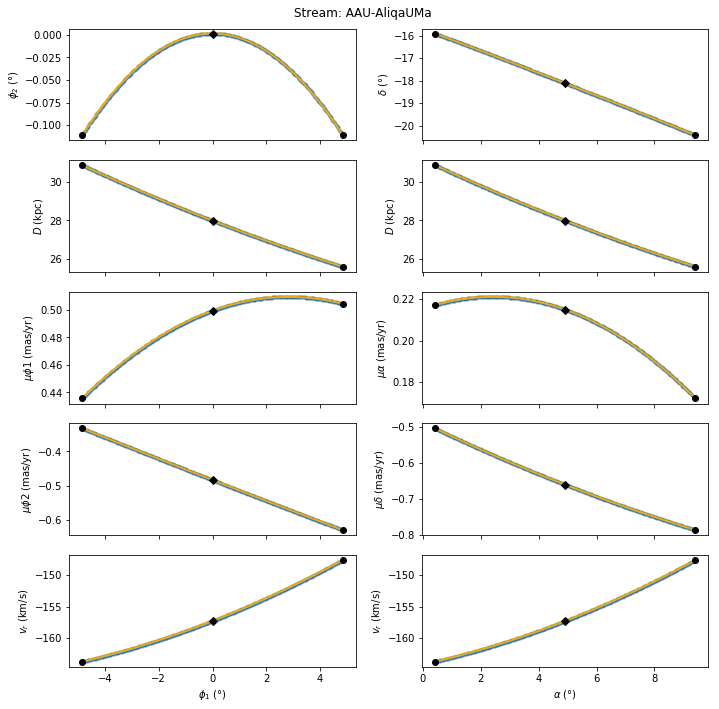

In [242]:
#interpolate
phi1s=np.linspace(-21,-11.5,300)

#track- Eq. 3
delta = 1.5*np.ones(phi1s.size)
phi2s = delta -0.5*((phi1s-3.)/10.)**2


#VGSR, pms - Eq. 1
x = phi1s/10.
VGSR = -131.33 + 0.07*x + 5.68*x**2
pm_ra_cosdec = -0.10-0.34*x-0.09*x**2
pm_dec = -0.96 -0.07*x +0.07*x**2

#mM
mM =16.66 -0.28*x + 0.045*x**2  #Eq. 2
D = 10**((mM+5)/5.)*1/1000.

zeros=np.zeros(phi1s.size)

R_radec_to_phi12= [[0.83697865, 0.29481904, -0.4610298],[0.51616778, -0.70514011, 0.4861566 ], [0.18176238, 0.64487142, 0.74236331]]

stream_frame = gc.GreatCircleICRSFrame.from_R(R_radec_to_phi12)
stream_track = ac.SkyCoord(phi1=phi1s*u.deg, phi2=phi2s*u.deg, distance=D*u.kpc, frame=stream_frame)

#Convert Vgsr back to heliocentric, using Schoenrich & Binney 2010. This is a guess. This is not explicitly mentioned 
vhel = gc.vgsr_to_vhel(coordinate=stream_track.icrs,vgsr=VGSR*u.km/u.s,vsun=(10.3,232.6,5.9)*u.km/u.s)

Ref = "Li2020"
Name,ShortName= "AAU-AliqaUMa","AAU-AU"

obs = ac.SkyCoord(ra=stream_track.icrs.ra, dec=stream_track.icrs.dec, distance=stream_track.distance, frame='icrs',
                  pm_ra_cosdec=pm_ra_cosdec*u.mas/u.yr, pm_dec=pm_dec*u.mas/u.yr, radial_velocity=vhel)


generate_track_from_points_plot_and_store(obs.icrs, Name, Ref, deg=2, mid_point=None, ShortName=ShortName, clf=False, plot_obs=True, InfoFlags="1111")




AAU-ATLAS -> track.st.AAU-ATLAS.li2020.ecsv


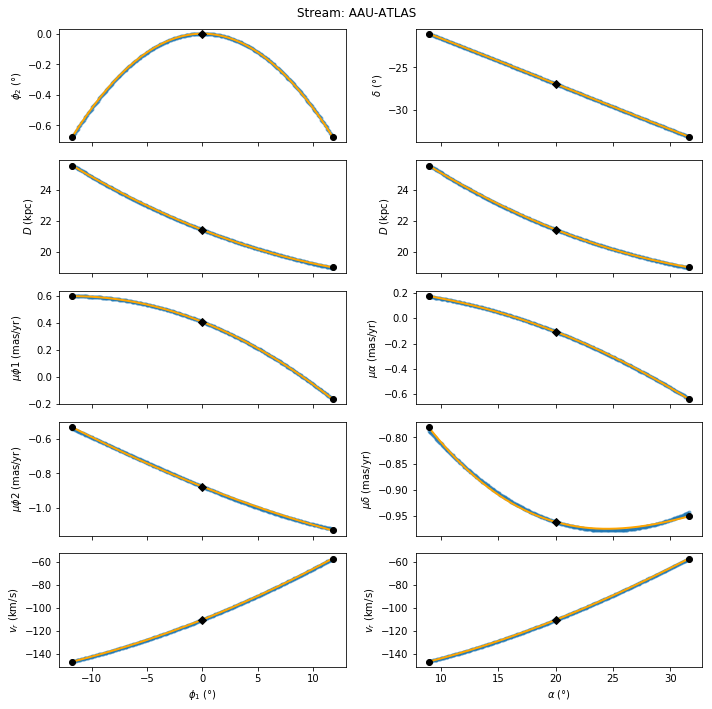

In [243]:
#interpolate
phi1s=np.linspace(-11.5,12,300)

#track
delta = 0.75*np.ones(phi1s.size)
phi2s = delta -0.5*((phi1s-3.)/10.)**2


#VGSR, pms
x = phi1s/10.
VGSR = -131.33 + 0.07*x + 5.68*x**2
pm_ra_cosdec = -0.10-0.34*x-0.09*x**2
pm_dec = -0.96 -0.07*x +0.07*x**2

#mM
mM =16.66 -0.28*x + 0.045*x**2
D = 10**((mM+5)/5.)*1/1000.

zeros=np.zeros(phi1s.size)

R_radec_to_phi12= [[0.83697865, 0.29481904, -0.4610298],[0.51616778, -0.70514011, 0.4861566 ], [0.18176238, 0.64487142, 0.74236331]]

stream_frame = gc.GreatCircleICRSFrame.from_R(R_radec_to_phi12)
stream_track = ac.SkyCoord(phi1=phi1s*u.deg, phi2=phi2s*u.deg, distance=D*u.kpc, frame=stream_frame)

#Convert Vgsr back to heliocentric, using Schoenrich & Binney 2010. This is a guess. This is not explicitly mentioned in Yam et al. 2013.
vhel = gc.vgsr_to_vhel(coordinate=stream_track.icrs,vgsr=VGSR*u.km/u.s,vsun=(10.3,232.6,5.9)*u.km/u.s)

Ref = "Li2020"
Name,ShortName= "AAU-ATLAS","AAU-A"

obs = ac.SkyCoord(ra=stream_track.icrs.ra, dec=stream_track.icrs.dec, distance=stream_track.distance, frame='icrs',
                  pm_ra_cosdec=pm_ra_cosdec*u.mas/u.yr, pm_dec=pm_dec*u.mas/u.yr, radial_velocity=vhel)


generate_track_from_points_plot_and_store(obs.icrs, Name, Ref, deg=2, mid_point=None, ShortName=ShortName, clf=False, plot_obs=True, InfoFlags="1111")




Sgr-A20
======

Sagittarius -> track.st.Sagittarius.antoja2020.ecsv


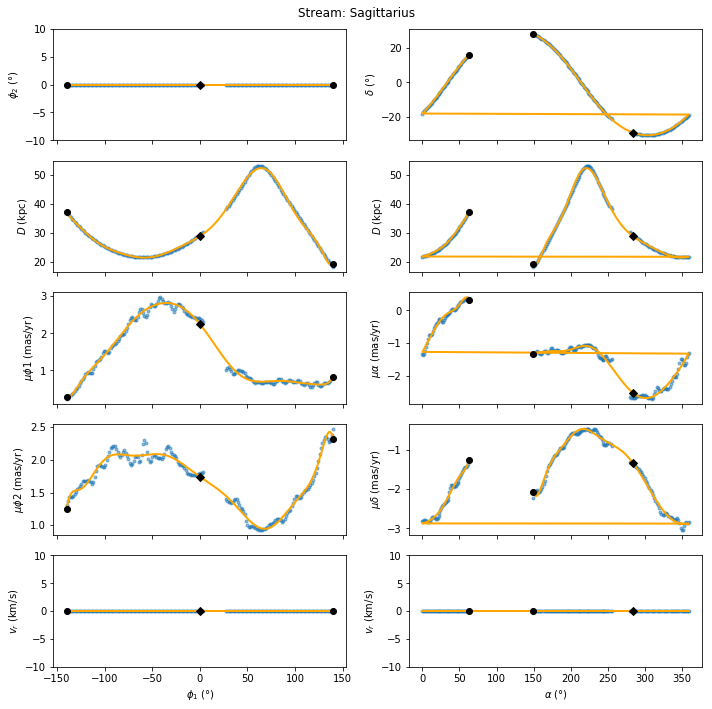

In [244]:
Lambda = np.linspace(-140,140,200) 
Beta = np.zeros(Lambda.size)

#Distance track from Ramos2020a
D = sagittarius.interpolators.sagittarius_properties(Lambda, proper_motion=False, distance=True, 
                                                                   frame='icrs', source='Strip')

#Tranform to galactic
sgr_fr = gc.SagittariusLaw10

#In Ramos2020 and Antoja2020 we use the B14 convention, in which L=360-L_LM10. Gala uses LM10
coo = ac.SkyCoord(Lambda=(360-Lambda)*u.deg,Beta=Beta*u.deg,frame=sgr_fr)

pm_l_cosb, pm_b = sagittarius.interpolators.sagittarius_properties(Lambda, proper_motion=True, 
                                                                   frame='galactic', source='A20').T

#Remove nans (otherwise, interpolation crashes)
m = (pm_b>-9999) & (pm_l_cosb>-9999) 
track = ac.SkyCoord(l=coo.galactic.l[m], b=coo.galactic.b[m], distance=D[m]*u.kpc, frame='galactic',
#                    pm_l_cosb=np.zeros(m.size)*u.mas/u.yr, pm_b= np.zeros(m.size)*u.mas/u.yr )
                     pm_l_cosb=pm_l_cosb[m]*u.mas/u.yr, pm_b= pm_b[m]*u.mas/u.yr )

Ref = "Antoja2020"
Name,ShortName= "Sagittarius","Sgr"


pole= ac.SkyCoord(Lambda=0.*u.deg,Beta=90.*u.deg,frame=sgr_fr).icrs
ra0 = ac.SkyCoord(Lambda=0.*u.deg,Beta=0.*u.deg,frame=sgr_fr).icrs.ra   #Belokurov convention 360-lambda
sgr_fr = gc.GreatCircleICRSFrame(pole=pole,ra0=ra0)

generate_track_from_points_plot_and_store(track, Name, Ref, deg=12, mid_point=None, stream_frame=sgr_fr,
                                          ShortName=ShortName, clf=False, plot_obs=True, InfoFlags="1110")


ACS and Monoceros
============

The proper motion tracks correspond to the median tracks in Fig. 5 of Ramos2020b (data provided by P. Ramos priv. comm.). The sky tracks were XXXX from Fig.! of Ramos2020b. Monoceros extends further towards $l>200^\circ$, but here we limit the tracks to the data provided in the blind identification conducted by Ramos2020b.
See also Laporte2020.

"The sky tracks correspond to the smoothed splined that better represents the mean Galactic longitude of the HEALpix where we detect these structures as a function of the Galactic Longitude." Muy

ACS -> track.st.ACS.ramos2020b.ecsv


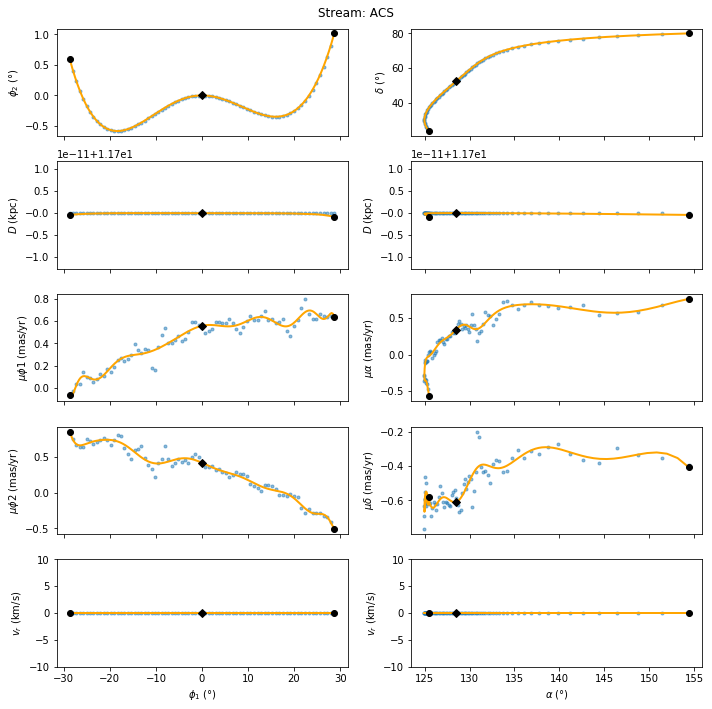

In [245]:
import pickle
with open('../support_data/ACS_sky.pkl', 'rb') as f:
    spl_loaded = pickle.load(f) 

mu_bin_edges = np.load("../support_data/mean_mub_vs_l_binning.npy")
l_centers = (mu_bin_edges[:-1] + mu_bin_edges[1:])/2.    
mul_arr = np.load('../support_data/mean_mul_vs_l_acs.npy')    
mub_arr = np.load('../support_data/mean_mub_vs_l_acs.npy')    
    
#ACS solo vale entre l = [130, 200]deg. MNC entre l = [140, 190]deg.
#MNC = 10.6kpc +-0.1 // ACS = 11.7kpc +- 0.2
m = (l_centers>=130.) & (l_centers<=200)
b = spl_loaded(l_centers)
ones = np.ones(b[m].size)

Ref = "Ramos2020b"
Name,ShortName= "ACS","ACS"

track = ac.SkyCoord(l=l_centers[m]*u.deg, b=b[m]*u.deg, frame='galactic',distance=11.7*ones*u.kpc,
                   pm_l_cosb=mul_arr[m]*u.mas/u.yr, pm_b=mub_arr[m]*u.mas/u.yr)

generate_track_from_points_plot_and_store(track, Name, Ref, deg=15, mid_point=None, 
                                          ShortName=ShortName, clf=False, plot_obs=True, InfoFlags="1110")


#plt.plot(l_centers[m],b,'.')
    

Monoceros -> track.st.Monoceros.ramos2020b.ecsv


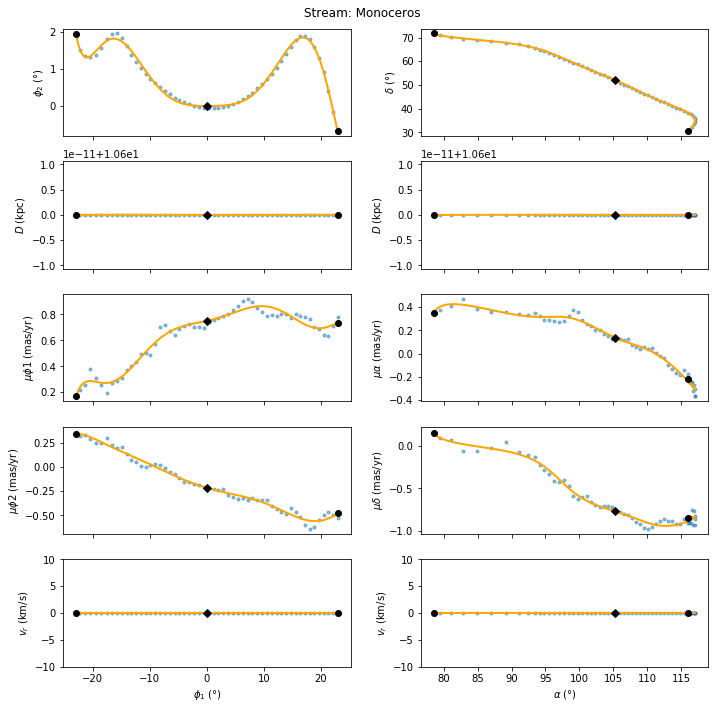

In [246]:
with open('../support_data/MNC_sky.pkl', 'rb') as f:
    spl_loaded = pickle.load(f) 

mu_bin_edges = np.load("../support_data/mean_mub_vs_l_binning.npy")
l_centers = (mu_bin_edges[:-1] + mu_bin_edges[1:])/2.    
mul_arr = np.load('../support_data/mean_mul_vs_l_mnc.npy')    
mub_arr = np.load('../support_data/mean_mub_vs_l_mnc.npy')    
    
#ACS solo vale entre l = [130, 200]deg. MNC entre l = [140, 190]deg.
#MNC = 10.6kpc +-0.1 // ACS = 11.7kpc +- 0.2
m = (l_centers>=140.) & (l_centers<=190.)
b = spl_loaded(l_centers)
ones=np.ones(b[m].size)

Ref = "Ramos2020b"
Name,ShortName= "Monoceros","MNC"

track = ac.SkyCoord(l=l_centers[m]*u.deg, b=b[m]*u.deg, frame='galactic', distance=10.6*ones*u.kpc,
                   pm_l_cosb=mul_arr[m]*u.mas/u.yr, pm_b=mub_arr[m]*u.mas/u.yr)

generate_track_from_points_plot_and_store(track, Name, Ref, deg=8, mid_point=None, 
                                          ShortName=ShortName, clf=False, plot_obs=True, InfoFlags="1110")



Jhelum a & b (Bonaca et al. 2019)
====================================


Jhelum-a -> track.st.Jhelum-a.bonaca2019.ecsv
Jhelum-b -> track.st.Jhelum-b.bonaca2019.ecsv


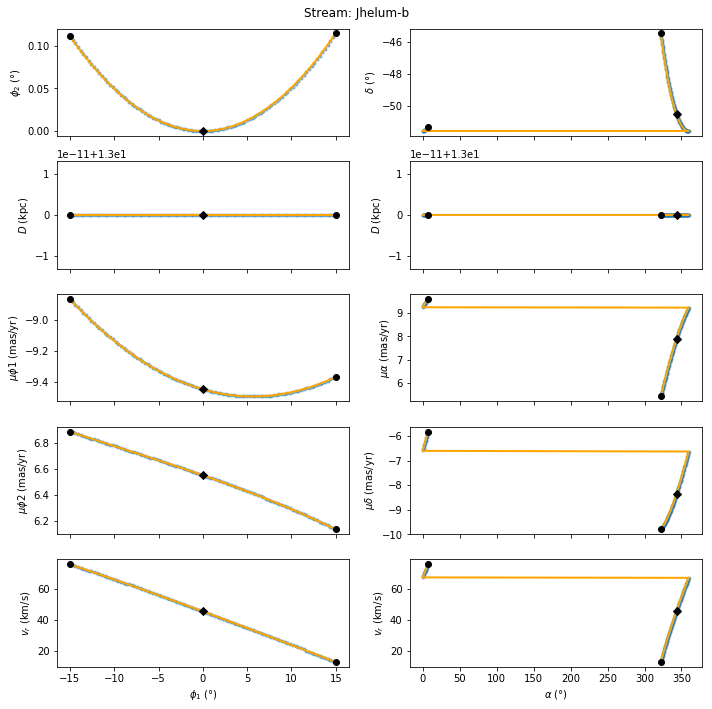

In [247]:
#Poly fit to main Jhelum component(a) Eq. 1 in Bonaca2019
phi1 = np.linspace(-5,25,100)
phi2_a = 0.000546*(phi1**2) -0.00217*phi1 + 0.583
phi2_b = phi2_a - 0.9

#Data from Bonaca2019 Figure 4.
tt= [-2.96, -7.26, 2.40, -7.42, 7.67, -7.49, 10.28, -7.51, 13.92, -7.51, 17.52, -7.47, 21.67, -7.40, 24.11, -7.33]
phi1_pm1 = tt[::2]
pm1 = tt[1::2]
pm1_fit = np.poly1d(np.polyfit(phi1_pm1,pm1, deg=3))
tt= [-2.95, 3.66, 2.14, 3.52, 6.54, 3.45, 10.94, 3.33, 16.75, 3.17, 21.97, 3.03, 24.10, 2.96]
phi1_pm2 = tt[::2]
pm2 = tt[1::2]
pm2_fit = np.poly1d(np.polyfit(phi1_pm2,pm2, deg=3))


D = 13.+0.*phi1
zeros = np.zeros(D.size)

R = np.load("../support_data/jhelum_rotmat_init_bonaca19.npy")
stream_frame = gc.greatcircle.GreatCircleICRSFrame.from_R(R)

Jhelum_a = ac.SkyCoord(phi1=phi1*u.deg, phi2=phi2_a*u.deg, distance=D*u.kpc, frame=stream_frame,
                       pm_phi1_cosphi2=pm1_fit(phi1)*u.mas/u.yr, pm_phi2=pm2_fit(phi1)*u.mas/u.yr,
                       radial_velocity=zeros*u.km/u.s)
Jhelum_b = ac.SkyCoord(phi1=phi1*u.deg, phi2=phi2_b*u.deg, distance=D*u.kpc, frame=stream_frame,
                       pm_phi1_cosphi2=pm1_fit(phi1)*u.mas/u.yr, pm_phi2=pm2_fit(phi1)*u.mas/u.yr,
                       radial_velocity=zeros*u.km/u.s)

#in Bonaca2019 they refer to PW-B 2018, there they use Schoenrich, Binney & Dennen 2010, Bovy 2015
#VLSR: Bovy, J. 2015, The Astrophysical Journal Supplement Series, 216, doi: 10.1088/0067-0049/216/2/29
Vsun_GSR = np.array([11.1,232.24,7.25])*u.km/u.s 
galactocentric_frame=ac.Galactocentric(galcen_distance=8.34*u.kpc,galcen_v_sun= -Vsun_GSR)

Jhelum_a_uncorr = gc.reflex_correct(Jhelum_a, galactocentric_frame=galactocentric_frame)
Jhelum_b_uncorr = gc.reflex_correct(Jhelum_b, galactocentric_frame=galactocentric_frame)

Ref = "Bonaca2019"
Name,ShortName= "Jhelum-a","Jhe-a"

generate_track_from_points_plot_and_store(Jhelum_a_uncorr, Name, Ref, deg=5, mid_point=None, 
                                          ShortName=ShortName, clf=True, plot_obs=True)

Ref = "Bonaca2019"
Name,ShortName= "Jhelum-b","Jhe-b"

generate_track_from_points_plot_and_store(Jhelum_b_uncorr, Name, Ref, deg=5, mid_point=None, 
                                          ShortName=ShortName, clf=False, plot_obs=True, InfoFlags="1011")


#plt.plot(phi1_mu2,mu2)
#plt.plot(phi1,phi2-0.9)
# plt.ylim(-5,5)

Pal 5 (Price-Whelan et al. 2019)
=====

The proper motion and distance tracks are implemented from the 2D polynomial coefficientes provided in their Table 1. The sky track is that from Bonaca et al. 2019 (Bonaca, A., Pearson, S., & Price-Whelan, A. M. 2019, arXiv:1910.00592)

Pal5 -> track.st.Pal5.pricewhelan2019.ecsv


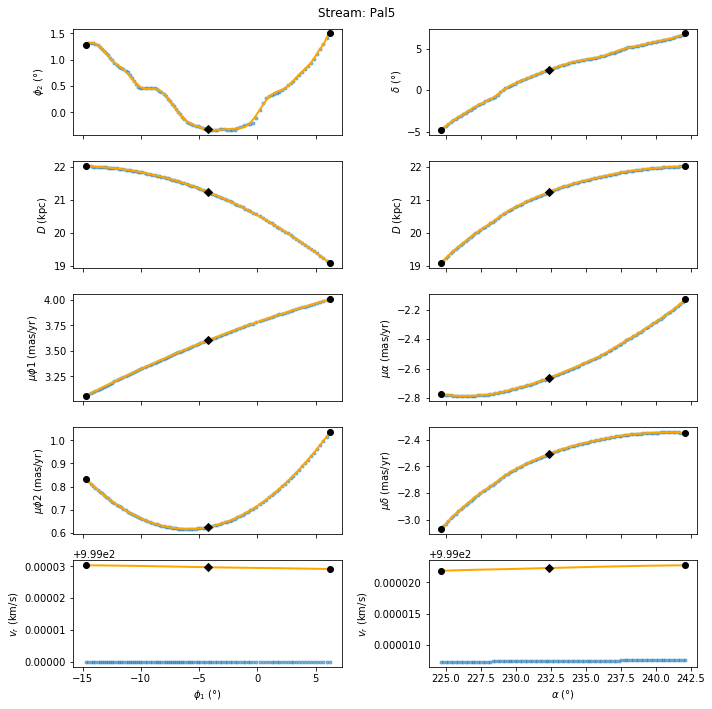

In [248]:
p5_track = pd.read_csv("../support_data/pal5_ridgeline.csv")
p5_track = p5_track.loc[np.argsort(p5_track.ra),:]
ra = np.linspace(np.min(p5_track.ra),np.max(p5_track.ra),100)
dec_fit=scipy.interpolate.CubicSpline(p5_track.ra,p5_track.dec, bc_type='natural')

pal5_frame = gc.Pal5PriceWhelan18

coo = ac.SkyCoord(ra=ra*u.deg, dec=dec_fit(ra)*u.deg, frame='icrs')
coo_fr = coo.transform_to(pal5_frame)

#This data is not corrected for the solar reflex (yay!)
phi1 = coo_fr.phi1.deg
x,a,b,c = -1.072, 3.740, 4.102e-2, -6.423e-4
pm1 = a + b*(phi1-x) + c*(phi1-x)**2
x,a,b,c = -10.954, 0.686, -2.826e-2, 2.832e-3
pm2 = a + b*(phi1-x) + c*(phi1-x)**2
x,a,b,c = -16.081, 22.022, 9.460e-3, -6.327e-3
D = a + b*(phi1-x) + c*(phi1-x)**2

zeros=np.zeros(ra.size)
coo = ac.SkyCoord(phi1=coo_fr.phi1, phi2=coo_fr.phi2, distance=D*u.kpc, frame=pal5_frame,
                  pm_phi1_cosphi2=pm1*u.mas/u.yr, pm_phi2=pm2*u.mas/u.yr, 
                  radial_velocity=(zeros+999)*u.km/u.s)
#mid_pt = ac.SkyCoord(phi1=0.*u.deg, phi2=0.*u.deg, distance=D*u.kpc, frame=pal5_frame)

# Vsun_GSR = np.array([11.1,232.24,7.25])*u.km/u.s 
# #galactocentric_frame=ac.Galactocentric(galcen_distance=8.34*u.kpc,galcen_v_sun= -Vsun_GSR)
# galactocentric_frame = ac.Galactocentric(galcen_distance=8.1*u.kpc, galcen_v_sun= -Vsun_GSR)

# #coo = gc.reflex_correct(coo, galactocentric_frame=galactocentric_frame)

Ref = "PriceWhelan2019"
Name,ShortName= "Pal5","Pal5"

generate_track_from_points_plot_and_store(coo, Name, Ref, deg=21, mid_point=None, stream_frame=pal5_frame,
                                          ShortName=ShortName, clf=False, plot_obs=True, InfoFlags="1110")



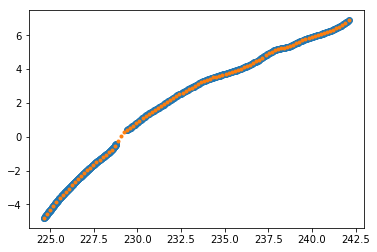

In [249]:
plt.plot(p5_track.ra,p5_track.dec,'o')
plt.plot(ra,dec_fit(ra),'.')

GD-1
========

In [250]:
tbl = astropy.table.Table.read('../support_data/gd1-with-masks.fits')
tbl = tbl[tbl['pm_mask'] & tbl['gi_cmd_mask'] & tbl['stream_track_mask']]

GD-1 -> track.st.GD-1.pricewhelan2018.ecsv


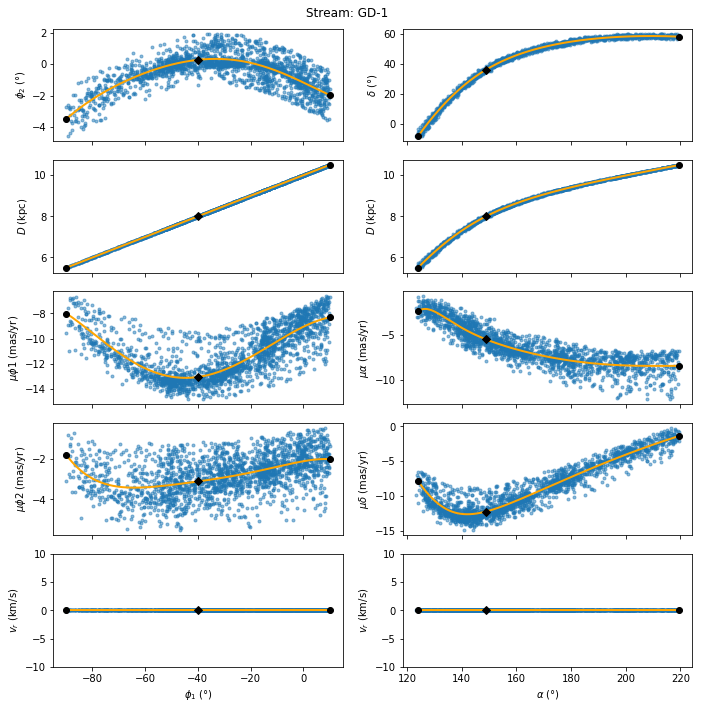

In [251]:
#Rotation Matrix from Koposov2010
R_radec_to_phi12 =[[-0.4776303088,-0.1738432154,0.8611897727],[0.510844589,-0.8524449229,0.111245042], [0.7147776536,0.4930681392,0.4959603976]]
gd1_frame = gc.GreatCircleICRSFrame.from_R(R_radec_to_phi12)

zeros = np.zeros_like(tbl["ra"])

#We assume the distance gradient assumed in Price-Whelan & Bonaca 2018
D = (0.05*tbl["phi1"]/u.deg+10)*u.kpc

coo = ac.SkyCoord(ra=tbl["ra"]*u.deg, dec=tbl["dec"]*u.deg, distance=D, 
                  pm_ra_cosdec=tbl["pmra"]*u.mas/u.yr, pm_dec=tbl["pmdec"]*u.mas/u.yr,
                  radial_velocity=zeros*u.km/u.s, frame='icrs')

Ref = "PriceWhelan2018"
Name,ShortName= "GD-1","GD-1"

generate_track_from_points_plot_and_store(coo, Name, Ref, deg=5, mid_point=None, stream_frame=gd1_frame,
                                          ShortName=ShortName, clf=False, plot_obs=True, InfoFlags="1110")


M92
======

Stream detection from Thomas et al. 2020 (http://arxiv.org/abs/2009.04487v1). The authors report the best fitting polynomial in tangent plane coordinates 

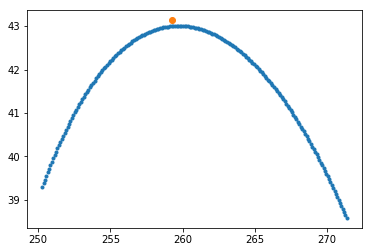

In [253]:
xi = np.linspace(-7,+9.5, 200)
eta = -0.134 +0.041*xi -0.056*(xi**2) +0.001*(xi**3)
xi = (xi*u.deg).to(u.rad)
eta = (eta*u.deg).to(u.rad) 

#M92 central coord
m92= ac.SkyCoord(ra="17h17m07.39s", dec="+43d08m09.4s")
rao, deco = m92.ra.to(u.deg), m92.dec.to(u.deg)

#Undo the tangent projection
ra = rao + ac.Angle(np.arctan( xi.value/(np.cos(deco)-eta.value*np.sin(deco))), unit=u.rad )
dec = ac.Angle(np.arcsin((np.sin(deco) + eta.value*np.cos(deco))/(np.sqrt(1 + xi.value**2 +  eta.value**2))), unit=u.rad).to(u.deg)

plt.plot(ra,dec,".")
plt.plot(rao,deco,'o')

M92 -> track.st.M92.thomas2020.ecsv


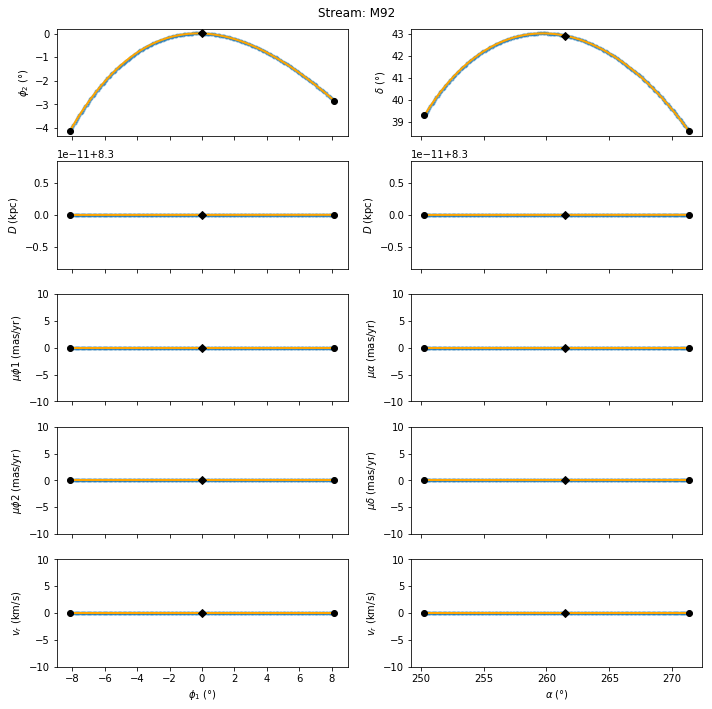

In [255]:
zeros = np.zeros(ra.size)

#We assume the distance gradient assumed in Price-Whelan & Bonaca 2018
D = 8.3*np.ones(ra.size)

coo = ac.SkyCoord(ra=ra.to(u.deg), dec=dec.to(u.deg), distance=D*u.kpc, 
                  pm_ra_cosdec=zeros*u.mas/u.yr, pm_dec=zeros*u.mas/u.yr,
                  radial_velocity=zeros*u.km/u.s, frame='icrs')

Ref = "Thomas2020"
Name,ShortName= "M92","M92"

generate_track_from_points_plot_and_store(coo, Name, Ref, deg=5, mid_point=None, stream_frame=None,
                                          ShortName=ShortName, clf=False, plot_obs=True, InfoFlags="1000")



Pal 15
=======

Computed from position angle (PA) and length of the tails from Myeong+ 2017. For each cluster they report the PA and length *l* for the 'tail 1' and 'tail 2', the two tails coming out of the cluster.

255.34633485050725 -1.4659310771061431
254.7683225240729 -0.12332105483752132
Pal15 -> track.st.Pal15.myeong2017.ecsv


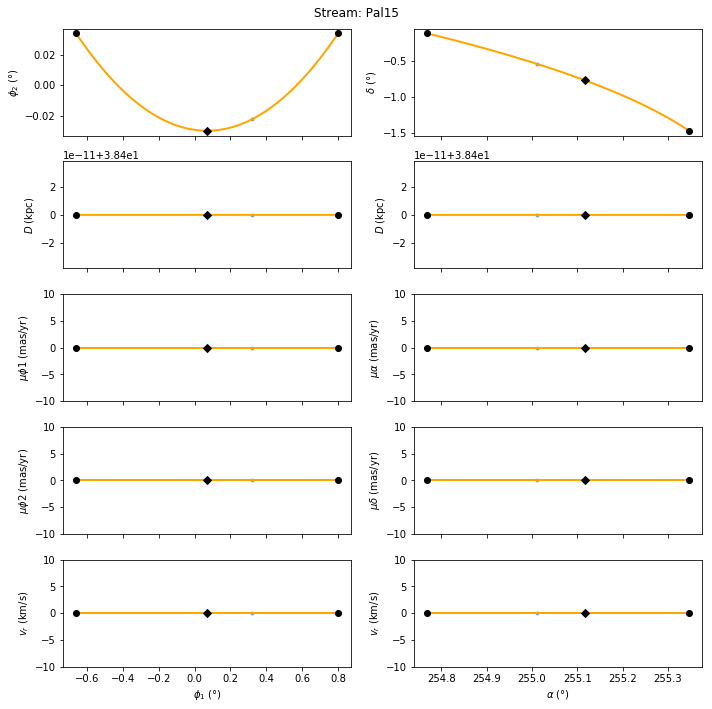

In [256]:
#Pal 15
rac,decc=255.01,-0.5419
l1,PA1=59./60.,np.radians(340.)
l2,PA2=29./60.,np.radians(150.)

delta_ra1=l1*np.sin(PA1)/np.cos(np.radians(decc))
delta_dec1=l1*np.cos(PA1)
delta_ra2=l2*np.sin(PA2)/np.cos(np.radians(decc))
delta_dec2=l2*np.cos(PA2)

#print delta_ra1*np.cos(np.radians(decc)),delta_dec1
#print delta_ra2*np.cos(np.radians(decc)),delta_dec2

ra1,dec1=rac -delta_ra1,decc-delta_dec1
ra2,dec2=rac -delta_ra2,decc-delta_dec2

print(ra1, dec1)
print(ra2,dec2)

ras  = np.array([ ra1, rac, ra2])
decs = np.array([dec1,decc,dec2])
zeros = np.zeros(ras.size)

#they report the cluster distance from Harris 1996
D = 38.4*np.ones(ras.size)

coo = ac.SkyCoord(ra=ras*u.deg, dec=decs*u.deg, distance=D*u.kpc, 
                  pm_ra_cosdec=zeros*u.mas/u.yr, pm_dec=zeros*u.mas/u.yr,
                  radial_velocity=zeros*u.km/u.s, frame='icrs')

Ref = "Myeong2017"
Name,ShortName= "Pal15","Pal15"

generate_track_from_points_plot_and_store(coo, Name, Ref, deg=2, mid_point=None, stream_frame=None,
                                          ShortName=ShortName, clf=False, plot_obs=True, InfoFlags="1000")



Eridanus
-------------------

Computed from position angle (PA) and length of the tails from Myeong+ 2017. For each cluster they report the PA and length *l* for the 'tail 1' and 'tail 2', the two tails coming out of the cluster.

65.97858431221822 -21.416713332935696
66.39221568778179 -20.957086667064306
Eridanus -> track.st.Eridanus.myeong2017.ecsv


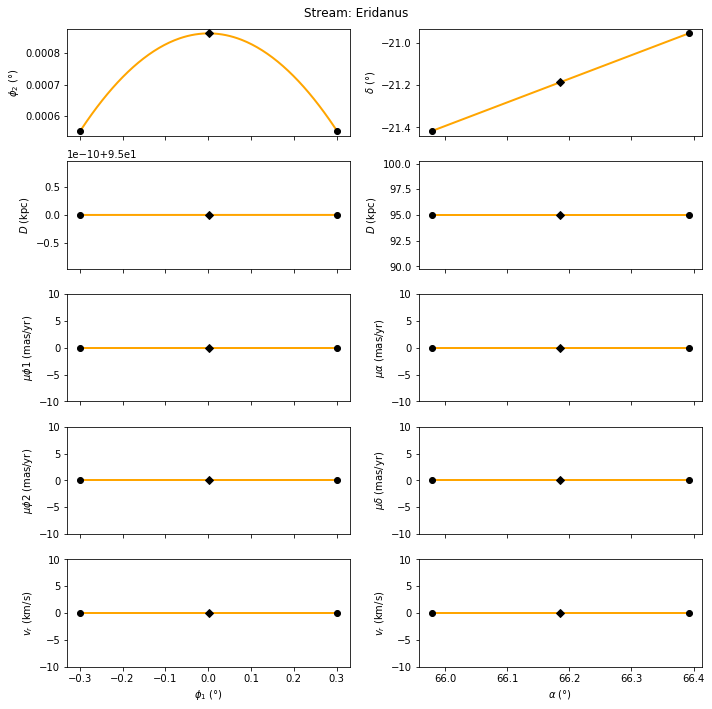

In [257]:
#Eridanus
rac,decc=66.1854,-21.1869
l1,PA1=18./60.,np.radians(40.)
l2,PA2=11./60.,np.radians(220.)

delta_ra1=l1*np.sin(PA1)/np.cos(np.radians(decc))
delta_dec1=l1*np.cos(PA1)
delta_ra2=l1*np.sin(PA2)/np.cos(np.radians(decc))
delta_dec2=l1*np.cos(PA2)

#print delta_ra1*np.cos(np.radians(decc)),delta_dec1
#print delta_ra2*np.cos(np.radians(decc)),delta_dec2

ra1,dec1=rac -delta_ra1,decc-delta_dec1
ra2,dec2=rac -delta_ra2,decc-delta_dec2

print(ra1, dec1)
print(ra2,dec2)

ras  = np.array([ ra1, rac, ra2])
decs = np.array([dec1,decc,dec2])
zeros = np.zeros(ras.size)

#they report the cluster distance from Harris 1996
D = 95.*np.ones(ras.size)

coo = ac.SkyCoord(ra=ras*u.deg, dec=decs*u.deg, distance=D*u.kpc, 
                  pm_ra_cosdec=zeros*u.mas/u.yr, pm_dec=zeros*u.mas/u.yr,
                  radial_velocity=zeros*u.km/u.s, frame='icrs')

Ref = "Myeong2017"
Name,ShortName= "Eridanus","Eri"

generate_track_from_points_plot_and_store(coo, Name, Ref, deg=2,  stream_frame=None,
                                          ShortName=ShortName, clf=False, plot_obs=True, InfoFlags="1000")




Computations for lib_by_pair or lib_by_pole
================================================================================================

Jet Stream
----

133.7568582473552 -27.702345529649296
141.99825582365125 -17.81505042193316


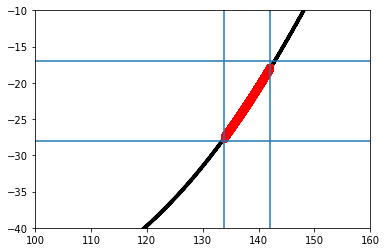

In [268]:
#props
dist=28.6 #kpc
width=0.18
#RA-DEC pole
gcra_all,gcdec_all=galstreams.gcutils.get_gc_for_pole(64.983, 34.747,degree=True,dlat=width)

plt.plot(gcra_all,gcdec_all,'k.',ms=1)

#Limit to reported RA and DEC ranges
ramin,ramax=15.*(8.+55./60.),15*(9.+28./60.)
decmin,decmax=-28.,-17.
#print ramin, ramax, decmin, decmax

jetmask=(gcra_all>=ramin) & (gcra_all<=ramax) & (gcdec_all>=decmin) & (gcdec_all<=decmax)
gcra_jet,gcdec_jet=gcra_all[jetmask],gcdec_all[jetmask]

plt.plot(gcra_jet,gcdec_jet,'ro')

plt.axvline(ramin)
plt.axvline(ramax)
plt.axhline(decmin)
plt.axhline(decmax)

plt.ylim(-40,-10)
plt.xlim(100,160)

#Print only end-points so this can be defined by lib_by_pair
print(gcra_jet[0],gcdec_jet[0])
print(gcra_jet[-1],gcdec_jet[-1])


Notes on Excluded Streams
===========

Icarus - Fiorentin et al. 2020 (arXiv:2012.10957v1)
-----

Identified in velocity space (U-V, V-W, Toomre diagram) with chemical data from GALAH and APOGEE-2. There is no celestial coordinate information in the paper. This stream is very close to the Sun (2.5kpc) and the stars probably surround it. It is excluded from the library.

Nyx - Necib et al. 2020
------

Nyx is a nearby stream of nearby stars identified kinematically by Necib et al. 2020. All the data is publicly available. It is also a stream in which the sun is embeded, so the stars are scattered all over the sky (see plot below). It is excluded from the library. 

In [9]:
Stars = pd.read_hdf('/Users/cmateu/Downloads/Public_SelectedByNetwork_5D.h5')

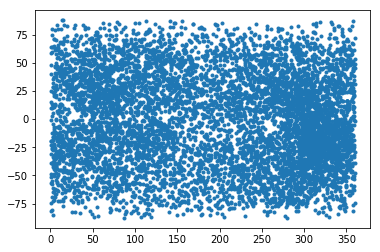

In [11]:
plt.plot(Stars["l"][::100],Stars["b"][::100],'.')

 S1-4 streams (Myeong et al. 2018)
 ---
*These streams/moving groups are too close or even surround the Sun, hence they are excluded from the library*

In [ ]:
#From Table 1, Myeong, et al. Monthly Notices RAS 475, 1537–1548 (2018). 
#Coordinates are galactocentric with Sun at +8.5 (approx., the paper is not explicit)
xyz_medians=[ (8.1,-0.2,2.8), (8.7,0.3,0.8), (8.6,0.5,3.5), (8.5,0.6,4.1)]
xyz_dispersions=[(0.8,1.2,1.9),(0.6,1.0,2.0), (1.1,1.5,1.9), (1.0,1.7,3.6)]
sns.set_style("whitegrid")
plt.figure(1,figsize=(12,8))
for ii in range(len(xyz_medians)):
    xs=np.random.normal(loc=xyz_medians[ii][0],scale=xyz_dispersions[ii][0],size=200)
    ys=np.random.normal(loc=xyz_medians[ii][1],scale=xyz_dispersions[ii][1],size=200)
    zs=np.random.normal(loc=xyz_medians[ii][2],scale=xyz_dispersions[ii][2],size=200)
    plt.subplot(2,4,ii+1)
    plt.title("S{0}".format(ii+1))
    plt.plot(xs,ys,'o',alpha=0.5)
    plt.grid(axis='both',which='both',lw=1)
    
    #Convert to heliocentric coords
#     ss=astropy.coordinates.SkyCoord(xs-8.5,ys,zs, unit='kpc',
#                                 representation='cartesian', frame='galactic')
    plt.subplot(2,4,5+ii)
#     plt.plot(ss.icrs.galactic.l,ss.icrs.galactic.b,'o',alpha=0.5)
    #Double check
    ll,bb,dd=bovyc.XYZ_to_lbd(xs-8.5,ys,zs,degree=True).T
    #plt.plot(ll,bb,'o',alpha=0.5)
    ssg=astropy.coordinates.SkyCoord(l=ll*astropy.units.deg,b=bb*astropy.units.deg,frame='galactic')
    plt.plot(ssg.l.wrap_at(180.*astropy.units.deg),ssg.b,'x')
plt.tight_layout()

#plt.plot(ssh.ra,ssh.dec,'o')

Extras - Playpen
====

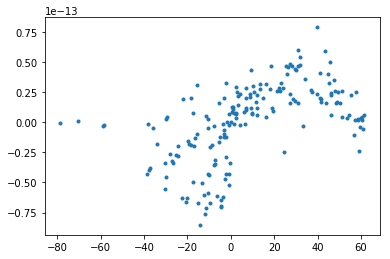

In [725]:
ibs.radial_velocity.min(),ibs.radial_velocity.max()
plt.plot(ibs.transform_to(stream_fr).phi1,ibs.transform_to(stream_fr).radial_velocity,'.')

In [726]:
ibs.transform_to(stream_fr).radial_velocity.min(),ibs.transform_to(stream_fr).radial_velocity.max()

(<Quantity -8.52602672e-14 km / s>, <Quantity 7.88789046e-14 km / s>)

Tests
======

In [266]:
#c_gc=c.transform_to(ac.Galactocentric)
#c_gc.spherical.lon